# ANALYSIS TOP FILMS

In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from collections import Counter, defaultdict
import community.community_louvain as community_louvain
import numpy as np
import re
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Create directed network.

Number of self-loops: 28
Number of nodes: 646
Number of edges: 3022


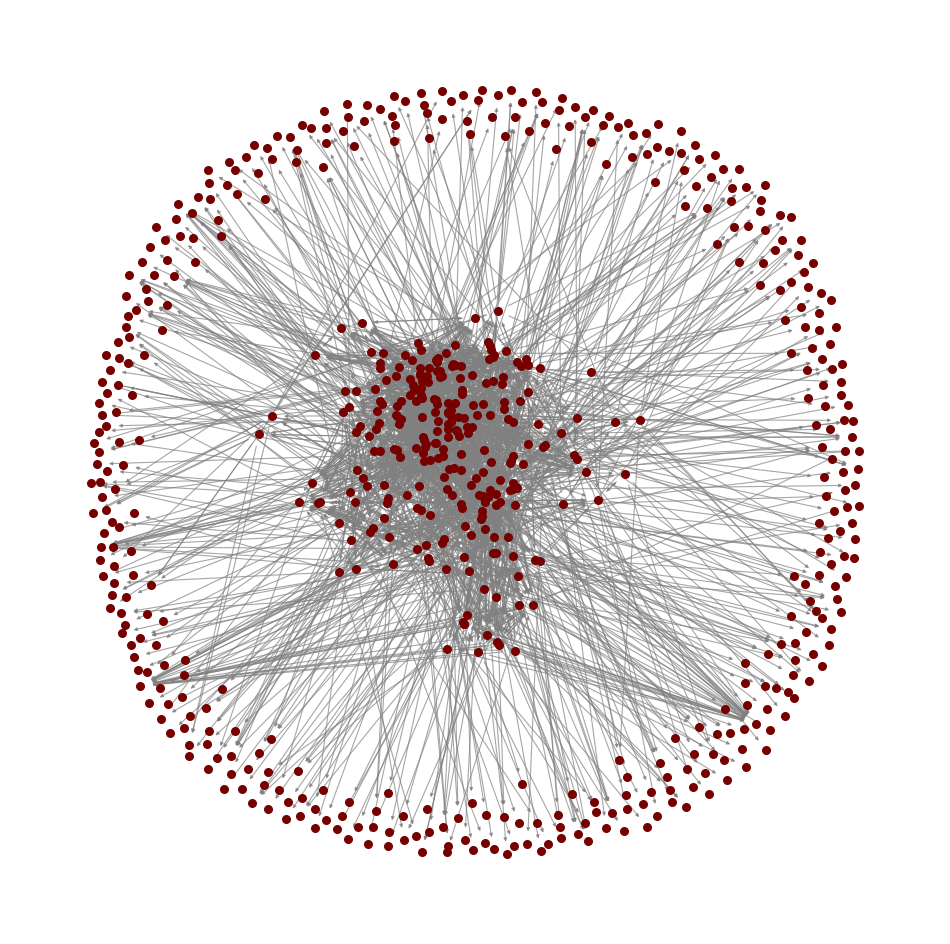

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('top_movie_data_with_similar.csv')

# Create an empty directed graph
D = nx.DiGraph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    D.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        D.add_edge(film, similar_film)

# Delete self-loops
self_loops = list(nx.selfloop_edges(D))
print("Number of self-loops:", len(self_loops))
D.remove_edges_from(self_loops)

# Num of nodes and edges
print("Number of nodes:", D.number_of_nodes())
print("Number of edges:", D.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(D, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(D, pos, edge_color='gray', alpha=0.7, width=0.8, arrowsize=5)
nx.draw_networkx_nodes(D, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Directed', fontsize=15)
plt.axis('off')
plt.show()

Save all node names in a txt.

<div class="alert alert-warning">
DONT RUN AGAIN!
</div>

In [21]:
# Save node names to a text file
node_names = list(D.nodes)
with open('top_net_movies_titles.txt', 'w') as file:
    for node in node_names:
        file.write(f"{node}\n")

print(f"Node names have been saved.")

Node names have been saved.


Add metadata to each node as attribute.

In [3]:
# Folder containing the text files
metadata_folder = 'top_net_movies_info'

# Function to parse a metadata text file and exclude the "Synopsis" field
def parse_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        key = None
        for line in lines:
            line = line.strip()
            if line.endswith(':'):
                key = line[:-1]  # Remove the colon
                if key == 'Synopsis':  # Skip "Synopsis"
                    key = None
                else:
                    metadata[key] = ''
            elif key:  # Append the value to the current key
                metadata[key] += (' ' + line if metadata[key] else line)
    return metadata

# Add metadata to the nodes in the graph
for node in D.nodes():
    # First, assume the filename matches the node title directly
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        if node == "Car Crash: Who's Lying?":
            sanitized_node = "Car Crash_ Who's Lying_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(D, {node: metadata})
    else:
        print(f"Metadata file not found for {node}")

In [4]:
# Check attributes of a specific node
sample_node = "Fight Club"
if sample_node in D.nodes:
    # Print the metadata of the node in one line each
    for key, value in D.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Fight Club 
Rating: 8.8 
Top 250 Rank: 13 
Duration: 139 
Release Date: 05 Nov 1999 (Denmark) 
Genres: Drama 
Director: David Fincher 
Actors: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Languages: English 
Description: A nameless first-person narrator attends support groups in an attempt to subdue his emotional state and relieve his insomniac state. When he meets Marla, another fake attendee of support groups, his life seems to become a little more bearable. However, when he associates himself with Tyler he is dragged into an underground fight club and soap-making scheme. Together the two men spiral out of control and engage in competitive rivalry for love and power. 
Plot: ['An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more.', 'A nameless first-person narrator attends support groups in an attempt 

Calculate distributions.

Text(0, 0.5, 'Frequency')

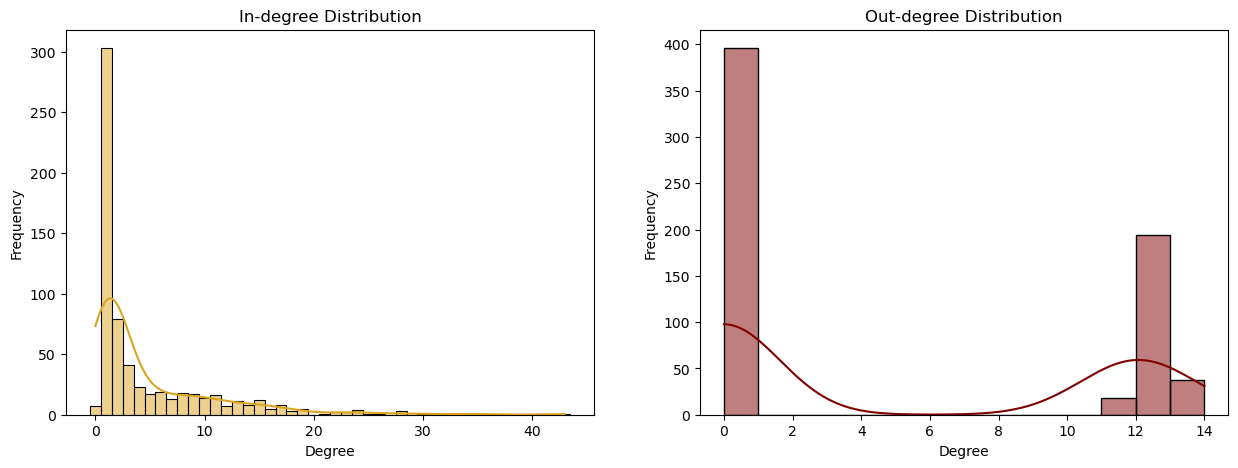

In [5]:
# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in D.in_degree()]
out_degrees = [d for n, d in D.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

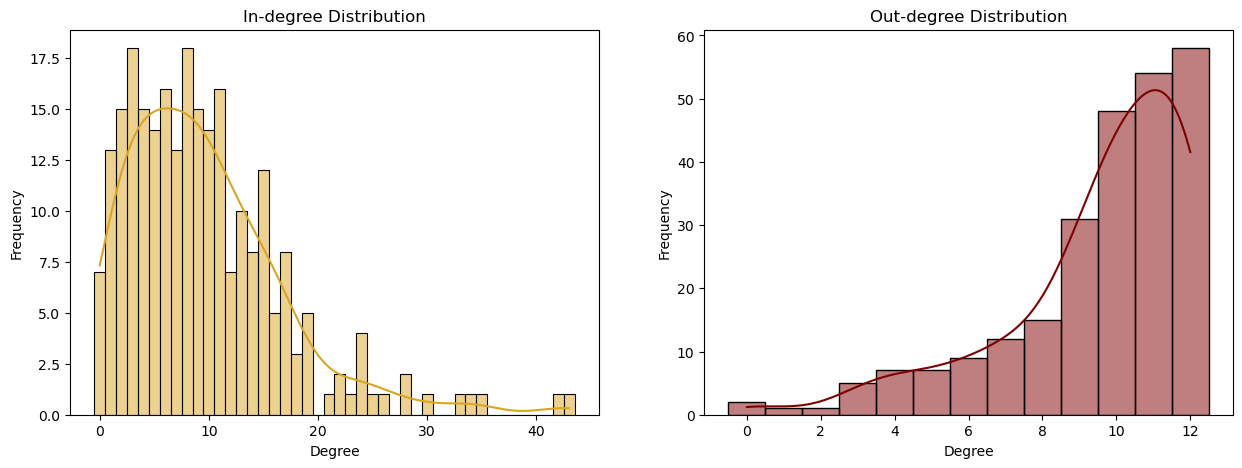

In [6]:
# Make a copy of the graph
H = D.copy()

# Remove the nodes with out-degree = 0
nodes_to_remove = [node for node, out_degree in dict(H.out_degree()).items() if out_degree == 0]
H.remove_nodes_from(nodes_to_remove)

# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in H.in_degree()]
out_degrees = [d for n, d in H.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Define bin range for out-degrees
binrange = (min(out_degrees) - 0.5, max(out_degrees) + 0.5)

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth, binrange=binrange)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Print top 5 in and out-degree movies.

In [7]:
# Top 5 nodes with highest in-degree with its genre and rating
in_degrees = dict(H.in_degree())
top_5_indegree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest in-degree:")
for node, indegree in top_5_indegree:
    print(f"{node} (In-degree: {indegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")

Top 5 nodes with highest in-degree:
Forrest Gump (In-degree: 43)
    Genres: Drama, Romance 
    Rating: 8.8 
Fight Club (In-degree: 42)
    Genres: Drama 
    Rating: 8.8 
Pulp Fiction (In-degree: 35)
    Genres: Crime, Drama 
    Rating: 8.9 
Inception (In-degree: 34)
    Genres: Action, Adventure, Sci-Fi, Thriller 
    Rating: 8.8 
Se7en (In-degree: 33)
    Genres: Crime, Drama, Mystery, Thriller 
    Rating: 8.6 


In [8]:
# Top 5 nodes with highest out-degree with its genre and rating
out_degrees = dict(H.out_degree())
top_5_outdegree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest out-degree:")
for node, outdegree in top_5_outdegree:
    print(f"{node} (Out-degree: {outdegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")

Top 5 nodes with highest out-degree:
The Shawshank Redemption (Out-degree: 12)
    Genres: Drama 
    Rating: 9.3 
The Dark Knight (Out-degree: 12)
    Genres: Action, Crime, Drama, Thriller 
    Rating: 9.0 
Forrest Gump (Out-degree: 12)
    Genres: Drama, Romance 
    Rating: 8.8 
Fight Club (Out-degree: 12)
    Genres: Drama 
    Rating: 8.8 
Pulp Fiction (Out-degree: 12)
    Genres: Crime, Drama 
    Rating: 8.9 


Make undirected network.

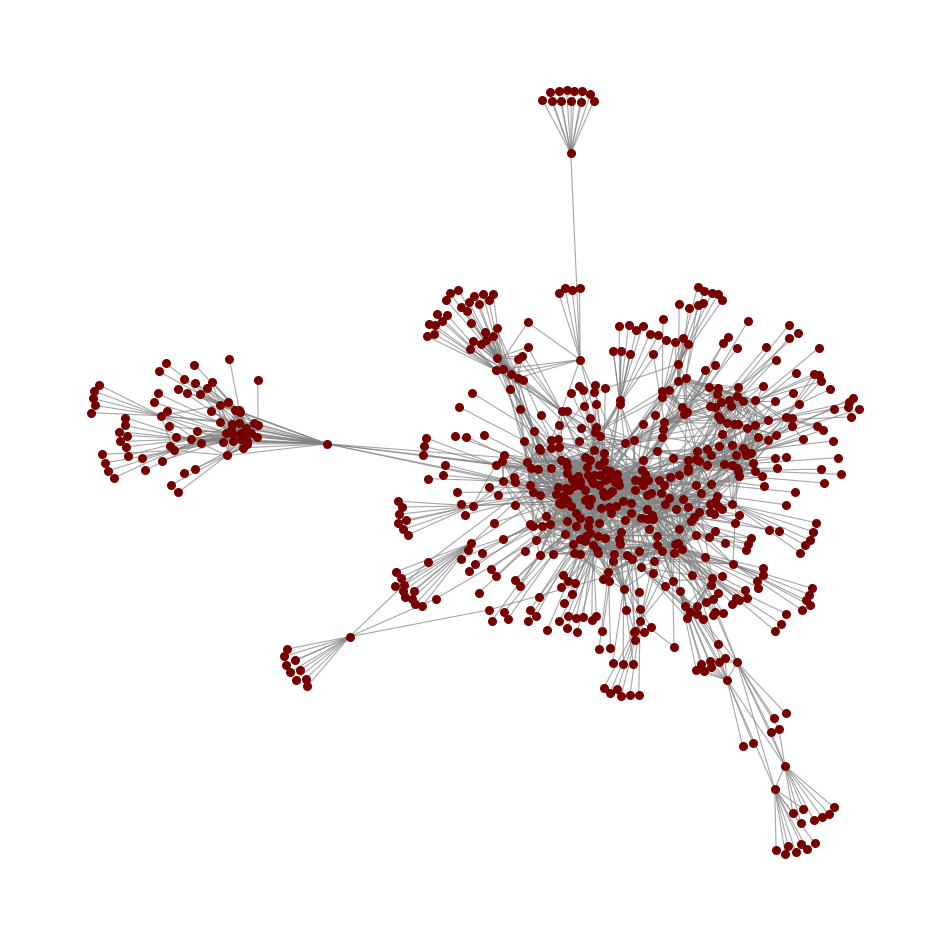

In [5]:
# Make undirected graph
G = D.to_undirected()

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(G, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Undirected', fontsize=15)
plt.axis('off')
plt.show()

In [6]:
# Check if the undirected graph has still attributes
sample_node = "Fight Club"
if sample_node in G.nodes:
    # Print the metadata of the node in one line each
    for key, value in G.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Fight Club 
Rating: 8.8 
Top 250 Rank: 13 
Duration: 139 
Release Date: 05 Nov 1999 (Denmark) 
Genres: Drama 
Director: David Fincher 
Actors: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Languages: English 
Description: A nameless first-person narrator attends support groups in an attempt to subdue his emotional state and relieve his insomniac state. When he meets Marla, another fake attendee of support groups, his life seems to become a little more bearable. However, when he associates himself with Tyler he is dragged into an underground fight club and soap-making scheme. Together the two men spiral out of control and engage in competitive rivalry for love and power. 
Plot: ['An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more.', 'A nameless first-person narrator attends support groups in an attempt 

Make communities:
- Genre partition

In [26]:
# Create a dictionary to hold the partition
genre_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Genres' attribute and split it into a list, if present
    genres = data.get("Genres", "")  # Default to an empty string if 'Genres' is missing
    genres_list = [g.strip() for g in genres.split(",")] if genres else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_genre = genres_list[0] if genres_list else None
    
    # Add node to the appropriate community in the partition
    if first_genre not in genre_partition:
        genre_partition[first_genre] = []
    genre_partition[first_genre].append(node)

print("Total number of genres:", len(genre_partition), "\n")
for genre, nodes in genre_partition.items():
    print(f"{genre}: {len(nodes)} nodes")

Total number of genres: 19 

Drama: 152 nodes
Action: 143 nodes
Crime: 68 nodes
Biography: 35 nodes
Short: 20 nodes
Adventure: 38 nodes
Comedy: 63 nodes
Music: 1 nodes
None: 2 nodes
Animation: 72 nodes
Documentary: 26 nodes
Mystery: 5 nodes
Horror: 14 nodes
News: 1 nodes
Film-Noir: 2 nodes
Fantasy: 1 nodes
Family: 1 nodes
Thriller: 1 nodes
Sport: 1 nodes


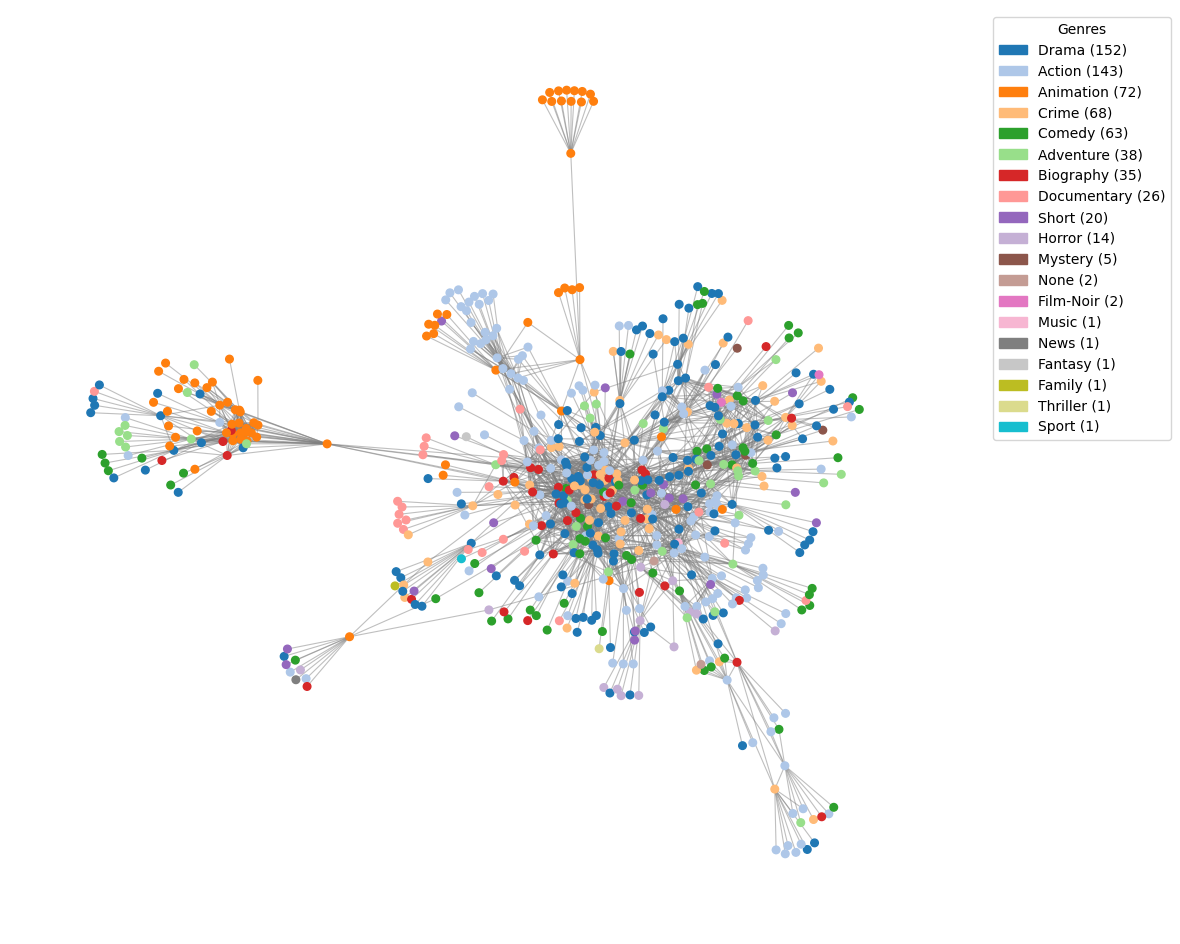

In [27]:
# Sort genres by the number of nodes, descending
sorted_genres = sorted(genre_partition.items(), key=lambda x: len(x[1]), reverse=True)

# Create a color map for each genre based on the sorted order
genre_to_color = {genre: plt.cm.tab20.colors[i % 20] for i, (genre, _) in enumerate(sorted_genres)}

# Create a list of colors for the nodes based on their genre
node_colors = []
for node in G.nodes:
    # Assign the corresponding color, default to "Unknown"
    assigned_color = "gray"  # Default to gray for nodes not matching any genre
    for genre, nodes in genre_partition.items():
        if node in nodes:
            assigned_color = genre_to_color[genre]
            break
    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Create a sorted legend
legend_handles = [
    mpatches.Patch(color=genre_to_color[genre], label=f"{genre} ({len(nodes)})")
    for genre, nodes in sorted_genres
]
plt.legend(handles=legend_handles, title="Genres", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.axis("off")
plt.show()


Calculate the modularity of the genre-based partition.

In [28]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in genre_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.32332278506770135


In [29]:
# Modularity using NetworkX
modularity_genre2 = nx.algorithms.community.modularity(G, [set(nodes) for nodes in genre_partition.values()])
print("Modularity of the genre-based partition (networkX formula):", modularity_genre2)

Modularity of the genre-based partition (networkX formula): 0.19655630558902218


- Director partition

In [30]:
# Create a dictionary to hold the partition
director_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Directors' attribute and split it into a list, if present
    directors = data.get("Director", "")  # Default to an empty string if 'Genres' is missing
    directors_list = [g.strip() for g in directors.split(",")] if directors else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_director = directors_list[0] if directors_list else None
    
    # Add node to the appropriate community in the partition
    if first_director not in director_partition:
        director_partition[first_director] = []
    director_partition[first_director].append(node)

print("Total number of directors:", len(director_partition), "\n")
for director, nodes in director_partition.items():
    print(f"{director}: {len(nodes)} nodes")

Total number of directors: 309 

Frank Darabont: 2 nodes
Christopher Nolan: 9 nodes
Francis Ford Coppola: 5 nodes
Robert Zemeckis: 4 nodes
David Fincher: 4 nodes
Quentin Tarantino: 8 nodes
Steven Spielberg: 10 nodes
Peter Jackson: 6 nodes
Sidney Lumet: 3 nodes
Martin Scorsese: 9 nodes
Jonathan Demme: 1 nodes
Lana Wachowski: 2 nodes
Todd Phillips: 2 nodes
None: 59 nodes
Cal Evans: 2 nodes
Roman Polanski: 3 nodes
Irvin Kershner: 1 nodes
Milos Forman: 2 nodes
Meg Pfeiffer: 1 nodes
Vidhu Vinod Chopra: 1 nodes
Rajkumar Hirani: 4 nodes
Nithilan Saminathan: 1 nodes
Nitesh Tiwari: 2 nodes
Kiran Rao: 1 nodes
Sandeep Reddy Vanga: 1 nodes
T.J. Gnanavel: 1 nodes
Nadine Labaki: 1 nodes
Nag Ashwin: 1 nodes
Nishikant Kamat: 1 nodes
Bahareh Ahmadi: 1 nodes
Liza Williams: 1 nodes
Pete Docter: 4 nodes
Roberto Benigni: 1 nodes
Richard Marquand: 1 nodes
George Lucas: 3 nodes
J.J. Abrams: 2 nodes
Rian Johnson: 1 nodes
Sudha Kongara: 1 nodes
Lokesh Kanagaraj: 2 nodes
Vetrimaaran: 1 nodes
Hanu Raghavapudi: 1

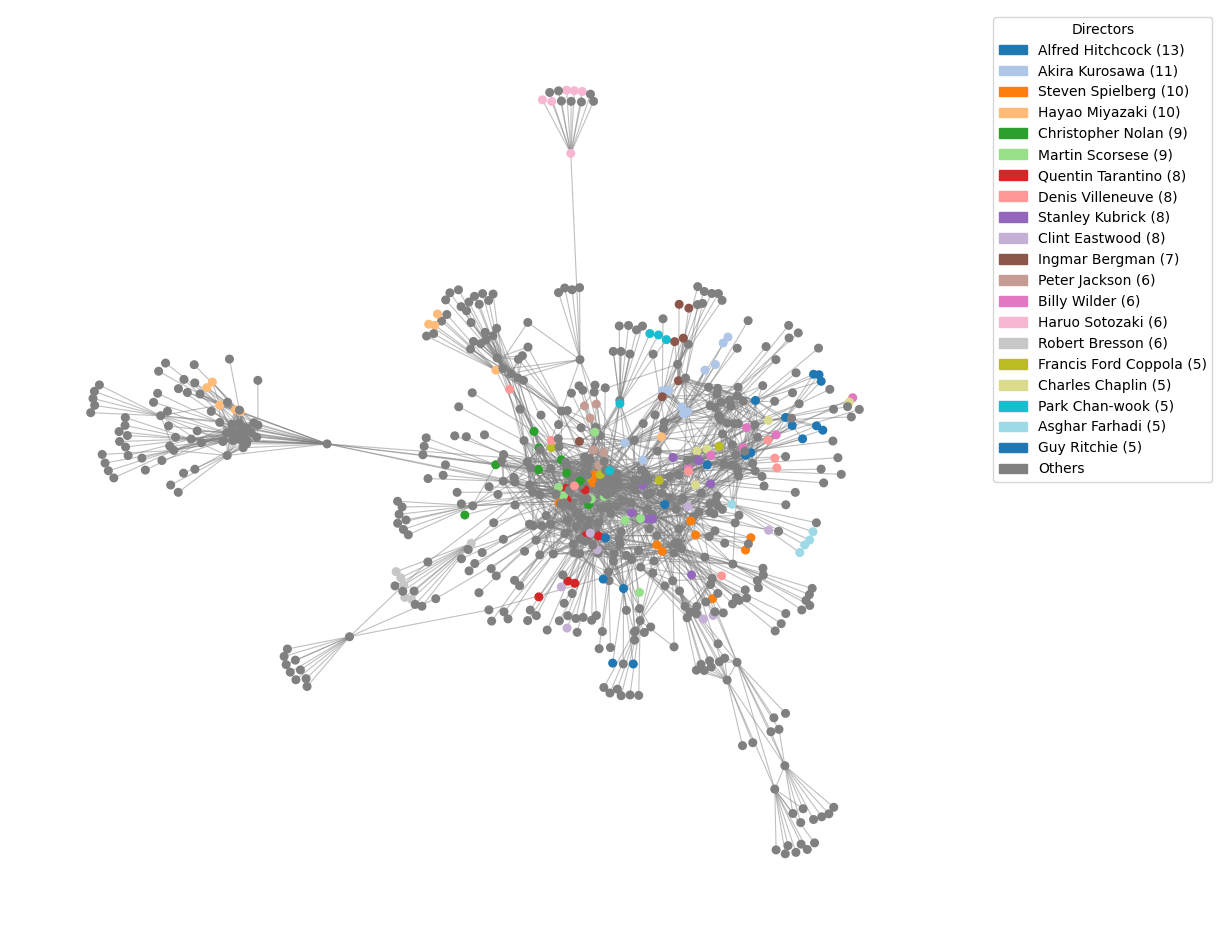

In [38]:
# Get the top 20 directors based on the number of movies (nodes), excluding 'None' or missing directors
top_20_directors = sorted(
    [(director, nodes) for director, nodes in director_partition.items() if director != "None" and director is not None],
    key=lambda x: len(x[1]), reverse=True
)[:20]

# Create a color map for the top 20 directors, excluding the gray color from tab20
# `tab20` has 20 colors, and we will avoid using the gray color.
tab20_colors = list(plt.cm.tab20.colors)  # Get all 20 colors
tab20_colors.remove(plt.cm.tab20.colors[14])  # Remove the gray color (index 14 in tab20)

# Create a color map for the top 20 directors using the remaining colors
director_to_color = {director: tab20_colors[i % len(tab20_colors)] for i, (director, _) in enumerate(top_20_directors)}

# Add a color for "Others" category using gray
others_color = 'gray'

# Create a list to store the color of each node based on its director
node_colors = []
for node in G.nodes:
    # Find the director of the current node by checking the partition_director dictionary
    assigned_color = others_color  # Default to "Others" for nodes without a top 20 director
    director = None  # Initialize to None (missing director)
    
    # Check the director partition and see if the node has a director
    for dir, nodes in director_partition.items():
        if node in nodes:
            director = dir
            break
    
    if director == "None" or director is None:  # If director is "None" or missing, assign to "Others"
        assigned_color = others_color
    elif director in director_to_color:  # If director is in top 20, assign the corresponding color
        assigned_color = director_to_color[director]
    else:  # If director is not in top 20, assign to "Others"
        assigned_color = others_color

    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Create a legend for the top 20 directors and "Others"
legend_handles = [
    mpatches.Patch(color=director_to_color[director], label=f"{director} ({len(nodes)})")
    for director, nodes in top_20_directors
]
legend_handles.append(mpatches.Patch(color=others_color, label="Others"))

# Add the legend
plt.legend(handles=legend_handles, title="Directors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove axis
plt.axis('off')

# Display the plot
plt.show()


Calculate modularity of the director based communities.

In [39]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_director = 0
for community in director_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_director += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the director-based partition (formula book):", modularity_director)

Modularity of the director-based partition (formula book): 0.1321586330306703


In [40]:
# Modularity using NetworkX
modularity_director2 = nx.algorithms.community.modularity(G, [set(nodes) for nodes in director_partition.values()])
print("Modularity of the director-based partition (networkX formula):", modularity_director2)

Modularity of the director-based partition (networkX formula): 0.12056134229494309


- Louvain partition

In [41]:
# Compute the Louvain partition
louvain_partition = community_louvain.best_partition(G)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in louvain_partition.items():
    community_groups[community].append(node)

print("Number of communities:", len(community_groups), "\n")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Number of communities: 11 

Community 1: 94 nodes
Community 6: 86 nodes
Community 0: 73 nodes
Community 5: 32 nodes
Community 7: 80 nodes
Community 9: 73 nodes
Community 10: 54 nodes
Community 4: 82 nodes
Community 2: 13 nodes
Community 3: 47 nodes
Community 8: 12 nodes


C:\Users\Alba\AppData\Local\Temp\ipykernel_20736\3809391496.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors


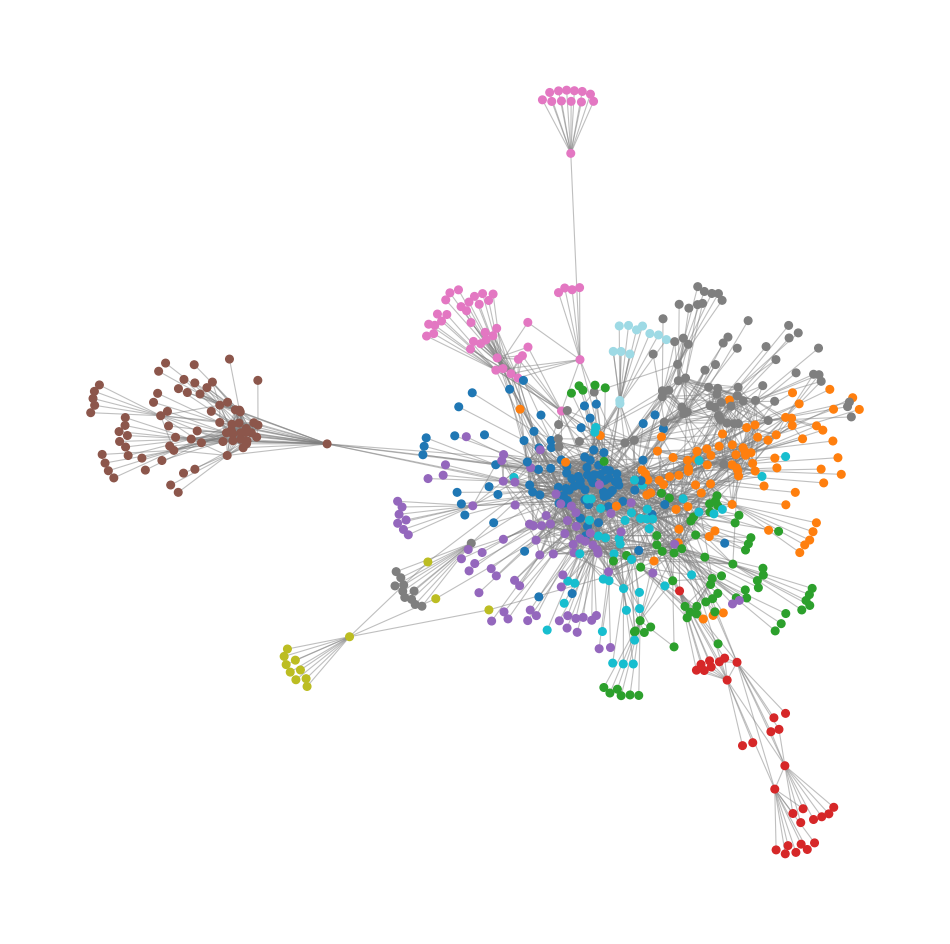

In [42]:

# Assign a unique color to each community
num_communities = len(community_groups)
color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors
community_to_color = {community: color_palette(i) for i, community in enumerate(community_groups.keys())}

# Create a list of colors for each node based on its community
node_colors = [community_to_color[louvain_partition[node]] for node in G.nodes]

# Plot the graph with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# # Add a title
# plt.title("Communities in Top Movies (Louvain Method)", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()

Calculate modularity of luvain communities.

In [43]:
# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(louvain_partition, G)
print("Modularity of Louvain partition:", modularity_louvain)

Modularity of Louvain partition: 0.6354189666855949


Calculate confussion matrix of genre partition vs louvain partition.

In [7]:
# Modify the nodes info to get it as list instead of string
G2 = nx.Graph(G)

# Modify the nodes to have lists of genres and directors
for node in G2.nodes:
    # Get the current node data
    data = G2.nodes[node]
    
    # Get the genres and directors as strings
    genres = data.get("Genres", "")
    directors = data.get("Director", "")
    actors = data.get("Actors", "")
    producers = data.get("Producer", "")
    production_companies = data.get("Production Companies", "")
    
    # Split the strings into lists
    genres_list = [g.strip() for g in genres.split(",")] if genres else []
    directors_list = [d.strip() for d in directors.split(",")] if directors else []
    actors_list = [a.strip() for a in actors.split(",")] if actors else []
    producers_list = [p.strip() for p in producers.split(",")] if producers else []
    production_companies_list = [pc.strip() for pc in production_companies.split(",")] if production_companies else []

    # Update the node data with the lists
    data["Genres"] = genres_list
    data["Director"] = directors_list
    data["Actors"] = actors_list
    data["Producer"] = producers_list
    data["Production Companies"] = production_companies_list

# Check the updated node data for a sample node
sample_node = "A Beautiful Mind"
if sample_node in G2.nodes:
    # Print the metadata of the node in one line each
    for key, value in G2.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: A Beautiful Mind 
Rating: 8.2 
Top 250 Rank: 150 
Duration: 135 
Release Date: 01 Mar 2002 (Denmark) 
Genres: ['Biography', 'Drama', 'Mystery']
Director: ['Ron Howard']
Actors: ['Russell Crowe', 'Ed Harris', 'Jennifer Connelly', 'Christopher Plummer', 'Paul Bettany', 'Adam Goldberg', 'Josh Lucas', 'Anthony Rapp', 'Jason Gray-Stanford', 'Judd Hirsch']
Languages: English 
Description: From the heights of notoriety to the depths of depravity, John Forbes Nash, Jr. experienced it all. A mathematical genius, he made an astonishing discovery early in his career and stood on the brink of international acclaim. But the handsome and arrogant Nash soon found himself on a painful and harrowing journey of self-discovery. After many years of struggle, he eventually triumphed over his tragedy, and finally - late in life - received the Nobel Prize. 
Plot: ['A mathematical genius, John Nash made an astonishing discovery early in his career and stood on the brink of international acclaim. But th

In [23]:
# Get the 10 most common genres
most_common_genres = sorted(genre_partition.keys(), key=lambda g: len(genre_partition[g]), reverse=True)[:10]

# Get 10 biggest communities
community_count = pd.Series(louvain_partition).value_counts()
most_common_communities = community_count.nlargest(10).index.tolist()

# Confusion matrix
D_matrix = np.zeros((len(most_common_genres), len(most_common_communities)), dtype=int)

for node in G2.nodes():
    # Get the genres directly from the node attributes
    node_genres = G2.nodes[node]['Genres']  # List of genres for the node
    node_community = louvain_partition[node]  # Community ID for the node
    
    # Check if the community is one of the largest ones
    if node_community in most_common_communities:
        community_index = most_common_communities.index(node_community)
        
        # Count all genres of this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                D_matrix[genre_index, community_index] += 1  # Increment the count in the matrix

# Display the confusion matrix
D_df = pd.DataFrame(D_matrix, index=most_common_genres, columns=most_common_communities)
print("Confusion Matrix (Genres vs Communities):")
print(D_df)


Confusion Matrix (Genres vs Communities):
              0   1   8   7   5   9   6   4   3   2
Drama        80  80  61  10  33  52  11  25  27  11
Action       30   9  10  44  11   3  43   6  15   2
Animation     0   2   2   1  38   0  27   4   0   0
Crime        29  20  29   1   2  13   2  13  12   5
Comedy        9  15  28   8  33  14   8   3   9   1
Adventure    19  12   5  39  45   4  35   1   4   0
Biography    10  13  11   1   6   2   1   4   3   0
Documentary   6   2   4   1   1   3   0   9   0   0
Short         4   7   6   5   0   2   1   1   0   0
Horror        3   2   4  23   2   2   0   1   1   5


## TF-IDF and wordclouds for genres and communities
First, start with genres.

In [52]:
synopsis = False

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

genre_text = {}

# Iterate over nodes in the graph and extract text data
for node, data in G2.nodes(data=True):
    genres = data.get("Genres", "")

    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        if node == "Car Crash: Who's Lying?":
            sanitized_node = "Car Crash_ Who's Lying_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?', '/']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        with open(metadata_file, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                if synopsis:
                    synopsis_text = line.strip()
                    synopsis_text = re.sub(r'[^\w\s]', '', synopsis_text) # Remove punctuation
                    synopsis_text = synopsis_text.lower() # Convert to lowercase
                    synopsis_text = re.sub(r"[^a-zA-Z\s]", " ", synopsis_text)  # Remove all non-alphabetic characters
                    synopsis_text = synopsis_text.lower()  # Convert text to lowercase
                    synopsis_text = re.sub(r"\b\w{1,2}\b", "", synopsis_text)  # Remove very short words (1-2 characters)
                    synopsis_text = re.sub(r"\s+", " ", synopsis_text).strip()  # Remove extra whitespace

                    # Remove stop words and lemmatize the words
                    words = word_tokenize(synopsis_text)
                    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
                    synopsis_text = " ".join(words)

                    # Agregate text for each genre
                    for genre in genres:
                        if genre not in genre_text:
                            genre_text[genre] = ""
                        genre_text[genre] += " " + synopsis_text
                    synopsis = False
                if line.strip().startswith("Synopsis:"):
                    synopsis = True

# Print genre_texts length
print("Genre's text length:")
for genre, text in genre_text.items():
    print(f"{genre}: {len(text)}")

Genre's text length:
Drama: 1474071
Action: 804892
Crime: 476873
Thriller: 649950
Romance: 268174
Adventure: 732185
Sci-Fi: 524770
Biography: 163066
History: 63437
Fantasy: 457107
Mystery: 371922
Musical: 53906
Short: 26
Western: 81088
War: 185070
Music: 23705
Comedy: 490933
Sport: 74522
Animation: 294478
Documentary: 6271
Family: 305926
Horror: 164710
Film-Noir: 47969
News: 1


In [53]:
# Tokenize the text for each genre
genre_tokens = {genre: word_tokenize(text) for genre, text in genre_text.items()}

# Count the frequency of each word in each genre
genre_word_counts = {genre: Counter(tokens) for genre, tokens in genre_tokens.items()}

In [54]:
# Generate TF list for the top 15 genres
top_genres = sorted(genre_word_counts.keys(), key=lambda x: len(genre_word_counts[x]), reverse=True)[:15]
genre_tf = {genre: {word: count for word, count in genre_word_counts[genre].items()} for genre, tokens in genre_tokens.items() if genre in top_genres}

In [55]:
# log-normalized TF for all the genres
tf_scores = {}
for genre, word_counts in genre_word_counts.items():
    tf_scores[genre] = {}
    for word, count in word_counts.items():
        tf_scores[genre][word] = 1 + math.log(count)

In [56]:
# Calculate the inverse document frequency (IDF) for each word

# Total number of genres
N = len(genre_tf)

# Initialize a Counter to store document frequencies
df_counts = Counter()

# Calculate document frequency for each word
for genre, word_list in genre_tf.items():
    df_counts.update(word_list.keys())

# Calculate IDF for each word
idf_scores = {}
for word, df in df_counts.items():
    idf_scores[word] = math.log(N/df)

In [57]:
# Calculate TF-IDF scores for each word in each genre
tfidf_scores = {}
for genre, word_list in genre_tf.items():
    tfidf_scores[genre] = {word: tf_scores[genre][word] * idf_scores[word] for word in word_list}

In [58]:
# Identify top 10 words based on TF-IDF scores
top_words_tfidf = {}
for genre, scores in tfidf_scores.items():
    # Sort words by TF-IDF score and get the top 10
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_tfidf[genre] = top_words

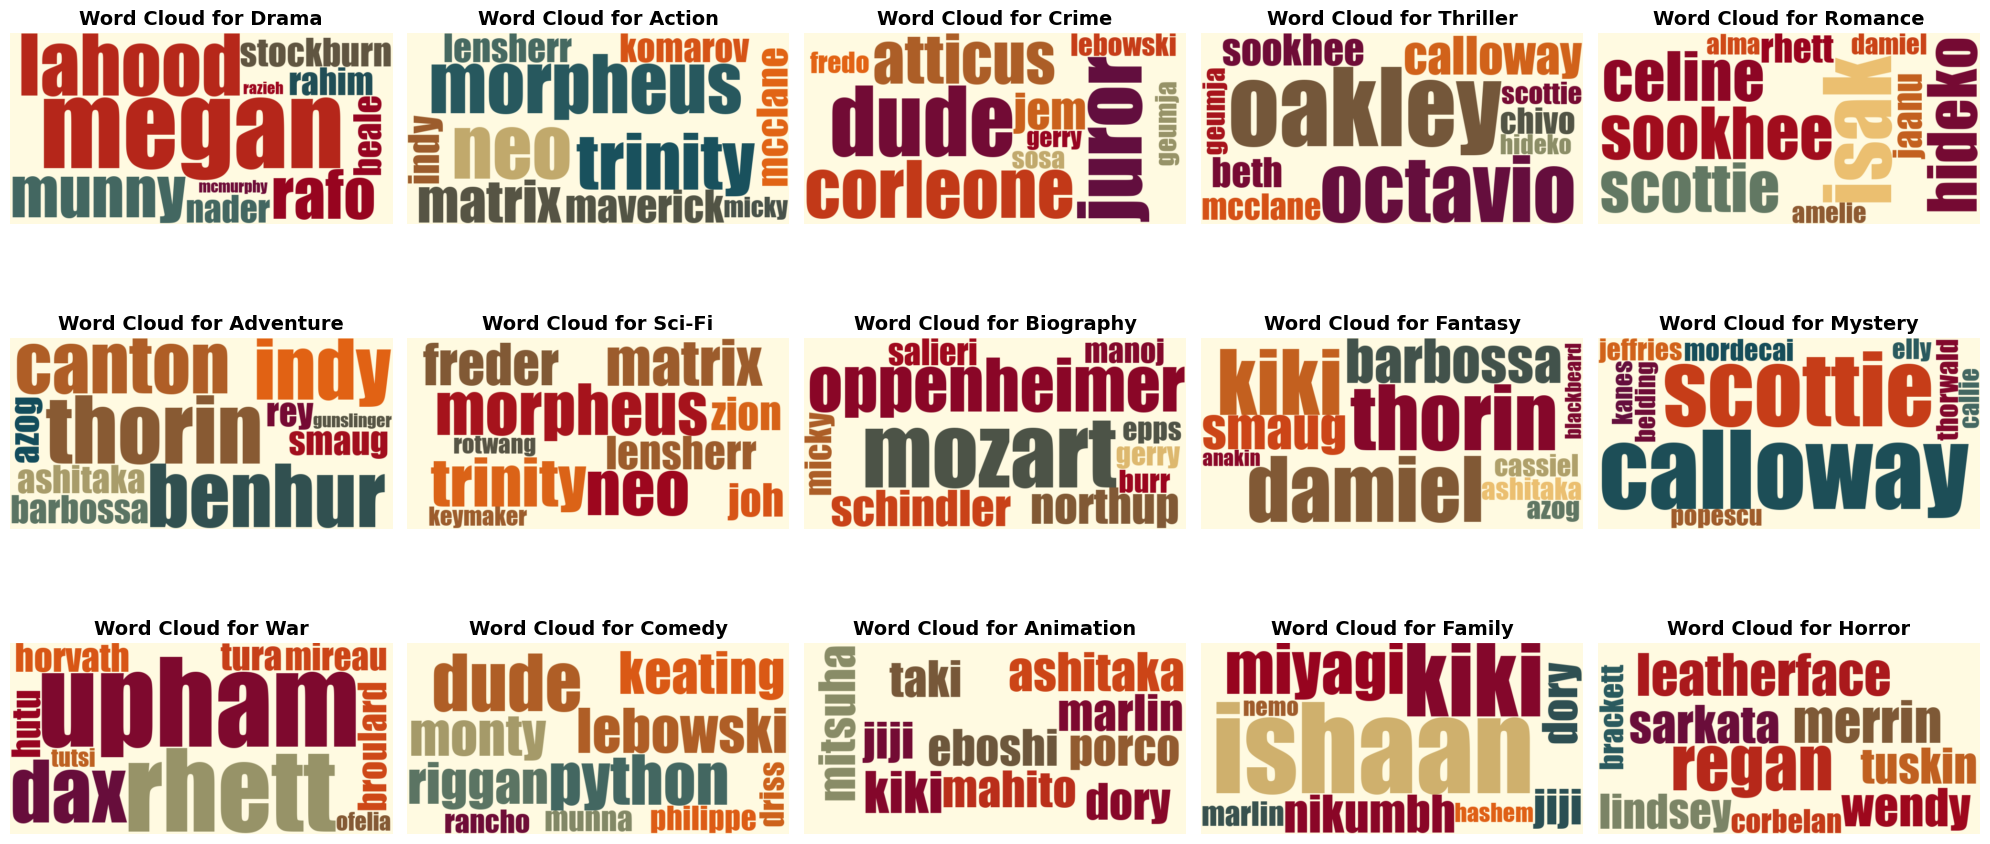

In [60]:
# Number of genres
num_genres = len(top_words_tfidf)

# Determine the number of rows and columns for the subplots
cols = 5
rows = (num_genres + cols - 1) // cols  # Proper ceiling division

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Define custom colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#5F0F40", "#9A031E", "#E36414", "#0F4C5C", "#EEC170"])

# Generate word clouds
for i, (genre, top_words) in enumerate(top_words_tfidf.items()):
    # Prepare a single string with each word repeated according to its TF-IDF score
    wordcloud_input = ' '.join([word for word, score in top_words for _ in range(int(score))])
    
    # Create the word cloud with custom font, color map, and background
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='#FFFAE1',
        colormap=cmap,
        font_path='C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/impact.ttf',  # Replace with a path to a custom font (optional)
        collocations=False
    ).generate(wordcloud_input)
    
    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for {genre}", fontsize=14, fontweight='bold')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Now with the communities.

In [61]:
synopsis = False

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

community_text = {}

# Iterate over nodes in the graph and extract text data
for community_id, nodes in community_groups.items():
    community_text[community_id] = ""

    for node in nodes:
        metadata_file = os.path.join(metadata_folder, f"{node}.txt")
        
        # If the file doesn't exist, try replacing ":" and "?" with "_"
        if not os.path.exists(metadata_file):
            if node == "Car Crash: Who's Lying?":
                sanitized_node = "Car Crash_ Who's Lying_"
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
            else:
                for char in [':', '?']:
                    sanitized_node = node.replace(char, '_')
                    metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                    if os.path.exists(metadata_file):
                        break
        
        # If the file exists, parse the metadata and add it to the node
        if os.path.exists(metadata_file):
            with open(metadata_file, 'r', encoding='utf-8') as file:
                lines = file.readlines()
                for line in lines:
                    if synopsis:
                        synopsis_text = line.strip()
                        synopsis_text = re.sub(r'[^\w\s]', '', synopsis_text) # Remove punctuation
                        synopsis_text = synopsis_text.lower() # Convert to lowercase
                        synopsis_text = re.sub(r"[^a-zA-Z\s]", " ", synopsis_text)  # Remove all non-alphabetic characters
                        synopsis_text = synopsis_text.lower()  # Convert text to lowercase
                        synopsis_text = re.sub(r"\b\w{1,2}\b", "", synopsis_text)  # Remove very short words (1-2 characters)
                        synopsis_text = re.sub(r"\s+", " ", synopsis_text).strip()  # Remove extra whitespace

                        # Remove stop words and lemmatize the words
                        words = word_tokenize(synopsis_text)
                        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
                        synopsis_text = " ".join(words)

                        # Agregate text for each community
                        community_text[community_id] += " " + synopsis_text
                        synopsis = False
                    elif line.strip().startswith("Synopsis:"):
                        synopsis = True

print("Community's text length:")
for community, text in community_text.items():
    print(f"{community}: {len(text)}")

Community's text length:
1: 503393
6: 271732
0: 349340
5: 105231
7: 239608
9: 300439
10: 187071
4: 224768
2: 26306
3: 179557
8: 51319


In [62]:
# Tokenize the text for each community
community_tokens = {community: word_tokenize(text) for community, text in community_text.items()}
community_word_counts = {community: Counter(tokens) for community, tokens in community_tokens.items()}
community_word_counts = {community: {word: count for word, count in counts.items() if count >= 5} for community, counts in community_word_counts.items()}

In [63]:
comunity_tf = {community: {word: count for word, count in counts.items()} for community, counts in community_word_counts.items()}

In [64]:
# log-normalize Tf for all the communities
tf_scores = {}
for community, word_list in comunity_tf.items():
    tf_scores[community] = {}  # Initialize an empty dictionary for each community
    for word, count in word_list.items():
        tf_scores[community][word] = 1 + math.log(count)

In [65]:
# Calculate the inverse document frequency (IDF) for each word
N = len(comunity_tf)  # Total number of communities
df_counts = Counter()  # Initialize a Counter to store document frequencies

# Calculate document frequency for each word
for community, word_list in comunity_tf.items():
    df_counts.update(word_list.keys())

# Calculate IDF for each word
idf_scores = {}
for word, df in df_counts.items():
    idf_scores[word] = math.log(N / df)

# Calculate TF-IDF scores for each word in each community
tfidf_scores = {}
for community, word_list in comunity_tf.items():
    tfidf_scores[community] = {word: tf_scores[community][word] * idf_scores[word] for word in word_list}

# Print the TF-IDF scores for the communities
# for community, scores in tfidf_scores.items():
    # print(f"TF-IDF scores for {community}:")
    # for word, score in scores.items():
        # print(f"{word}: {score:.4f}")
    # print("\n")

In [66]:
top_words_tfidf = {}
for community, scores in tfidf_scores.items():
    # Sort words by TF-IDF score and get the top 10
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_tfidf[community] = top_words

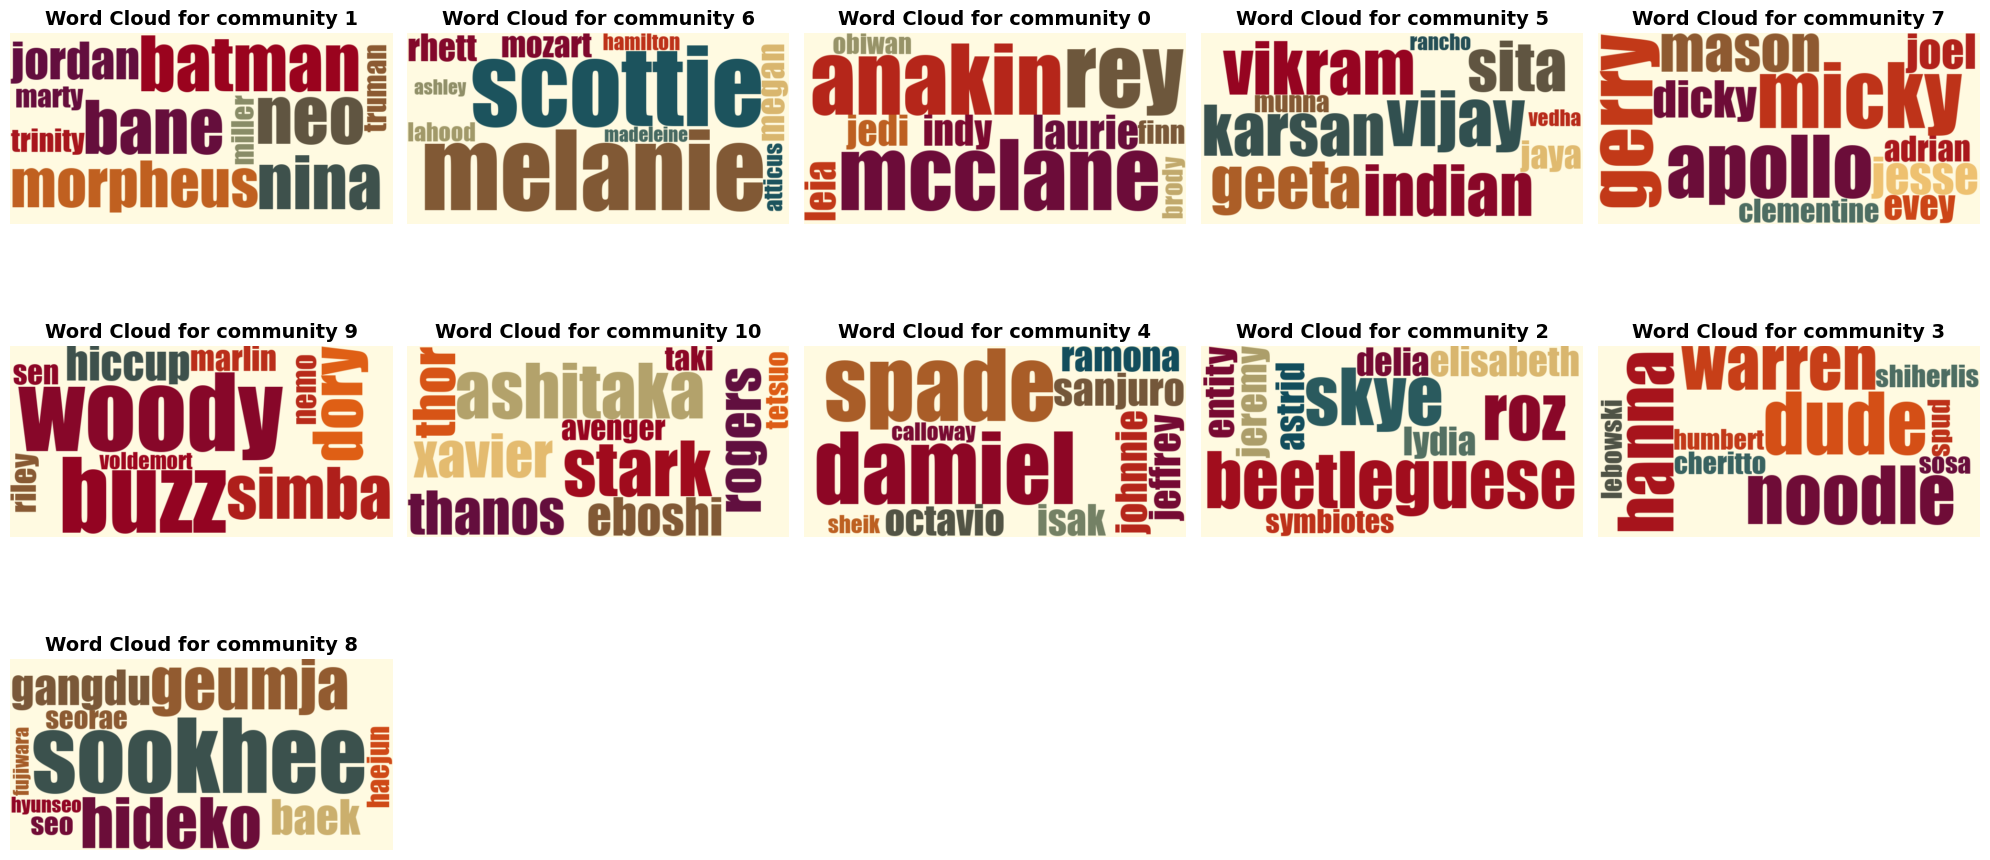

In [67]:

# Number of genres
num_communities = len(top_words_tfidf)

# Determine the number of rows and columns for the subplots
cols = 5
rows = (num_communities + cols - 1) // cols  # Proper ceiling division

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Define custom colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#5F0F40", "#9A031E", "#E36414", "#0F4C5C", "#EEC170"])

# Generate word clouds
for i, (community, top_words) in enumerate(top_words_tfidf.items()):
    # Prepare a single string with each word repeated according to its TF-IDF score
    wordcloud_input = ' '.join([word for word, score in top_words for _ in range(int(score))])
    
    # Create the word cloud with custom font, color map, and background
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='#FFFAE1',
        colormap=cmap,
        font_path='C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/impact.ttf',  # Replace with a path to a custom font (optional)
        collocations=False
    ).generate(wordcloud_input)
    
    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for community {community}", fontsize=14, fontweight='bold')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# ANALYSIS BOTTOM FILMS
Digraph is called K and normal graph is called M for bottom movies!

Number of self-loops: 48
Number of nodes: 1762
Number of edges: 2911


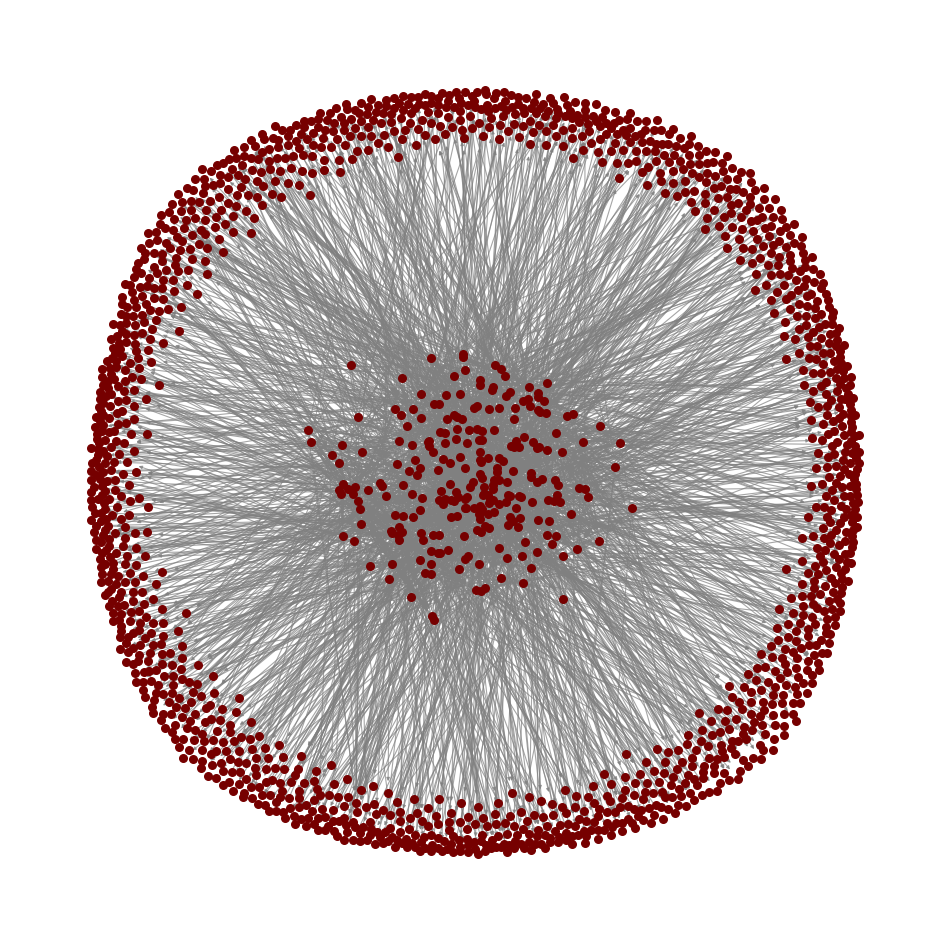

In [8]:
# Load the CSV file into a DataFrame
df = pd.read_csv('bottom_movie_data_with_similar.csv')

# Create an empty directed graph
K = nx.DiGraph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    K.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        K.add_edge(film, similar_film)

# Delete self-loops
self_loops = list(nx.selfloop_edges(K))
print("Number of self-loops:", len(self_loops))
K.remove_edges_from(self_loops)

# Num of nodes and edges
print("Number of nodes:", K.number_of_nodes())
print("Number of edges:", K.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(K, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(K, pos, edge_color='gray', alpha=0.7, width=0.8, arrowsize=5)
nx.draw_networkx_nodes(K, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Directed', fontsize=15)
plt.axis('off')
plt.show()

In [69]:
# Check strong connectivity
is_strongly_connected = nx.is_strongly_connected(K)
print("Is the graph strongly connected?", is_strongly_connected)

# Check weak connectivity
is_weakly_connected = nx.is_weakly_connected(K)
print("Is the graph weakly connected?", is_weakly_connected)

Is the graph strongly connected? False
Is the graph weakly connected? False


Number of nodes in the largest connected component: 1138
Number of edges in the largest connected component: 2033


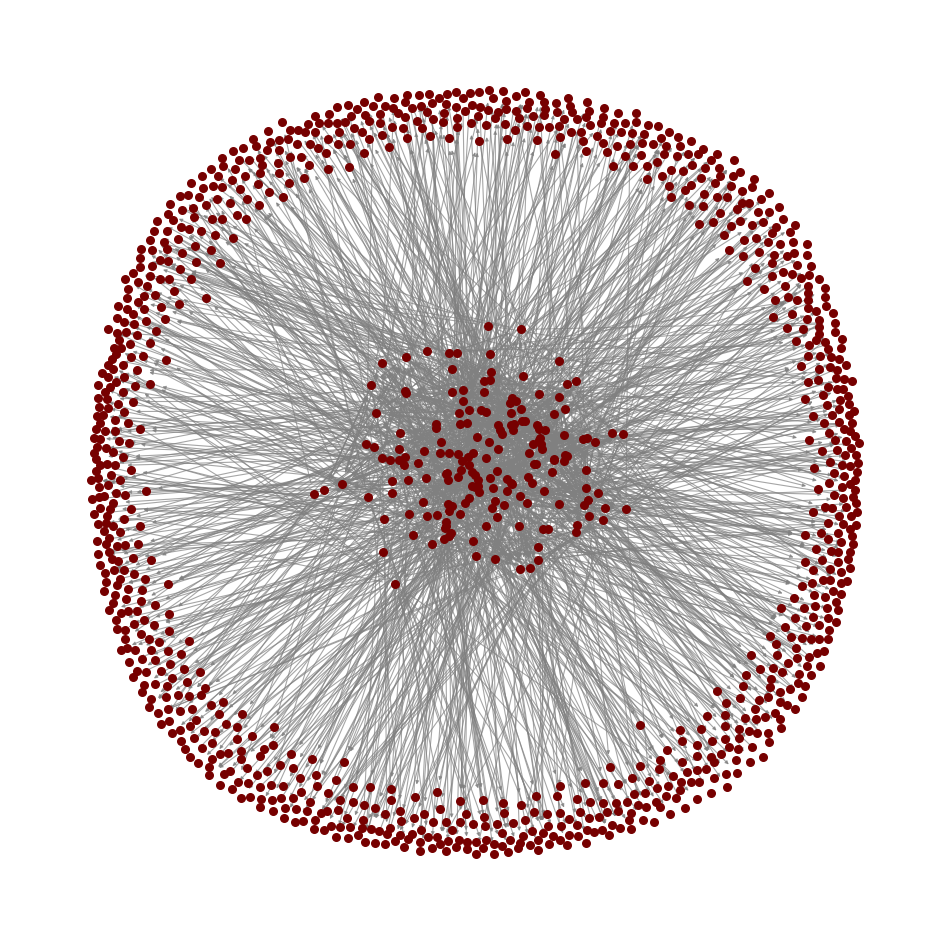

In [9]:
# Get weakly connected components
components = nx.weakly_connected_components(K)

# Find the largest connected component (by number of nodes)
largest_component = max(components, key=len)

# Create a subgraph containing only this component
K_largest = K.subgraph(largest_component).copy()

# Check the properties of the new subgraph
print("Number of nodes in the largest connected component:", K_largest.number_of_nodes())
print("Number of edges in the largest connected component:", K_largest.number_of_edges())

# Optionally, plot the largest connected component
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(K_largest, seed=42)
nx.draw_networkx_edges(K_largest, pos, edge_color='gray', alpha=0.7, width=0.8, arrowsize=5)
nx.draw_networkx_nodes(K_largest, pos, node_color='#760000', node_size=30)
plt.axis('off')
plt.show()


Save all node names in a txt.

<div class="alert alert-warning">
DONT RUN AGAIN!
</div>

In [ ]:
# Save node names to a text file
node_names = list(K_largest.nodes)
with open('bottom_net_movies_titles.txt', 'w') as file:
    for node in node_names:
        file.write(f"{node}\n")

print(f"Node names have been saved.")

Add metadata to each node as attribute.

In [10]:
# Folder containing the text files
metadata_folder = 'bottom_net_movies_info'

# Function to parse a metadata text file and exclude the "Synopsis" field
def parse_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        key = None
        for line in lines:
            line = line.strip()
            if line.endswith(':'):
                key = line[:-1]  # Remove the colon
                if key == 'Synopsis':  # Skip "Synopsis"
                    key = None
                else:
                    metadata[key] = ''
            elif key:  # Append the value to the current key
                metadata[key] += (' ' + line if metadata[key] else line)
    return metadata

# Add metadata to the nodes in the graph
for node in K_largest.nodes():
    # First, assume the filename matches the node title directly
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":", "?" and "/" with "_"
    if not os.path.exists(metadata_file):
        if node == "Naked Gun 33 1/3: The Final Insult":
            sanitized_node = "Naked Gun 33 1_3_ The Final Insult"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        elif node == "The Room Actors: Where Are They Now?":
            sanitized_node = "The Room Actors_ Where Are They Now_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        elif node == "Enes Batur: Imagination or Reality?":
            sanitized_node = "Enes Batur_ Imagination or Reality_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?', '/']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(K_largest, {node: metadata})
    else:
        print(f"Metadata file not found for {node}")

In [11]:
# Check attributes of a specific node
sample_node = "After"
if sample_node in K_largest.nodes:
    # Print the metadata of the node in one line each
    for key, value in K_largest.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: After 
Rating: 5.3 
Top 250 Rank: N/A 
Duration: 105 
Release Date: 11 Apr 2019 (Denmark) 
Genres: Drama, Romance 
Director: Jenny Gage 
Actors: Josephine Langford, Hero Fiennes Tiffin, Khadijha Red Thunder, Dylan Arnold, Shane Paul McGhie, Samuel Larsen, Inanna Sarkis, Selma Blair, Pia Mia, Swen Temmel 
Languages: English 
Description: Based on Anna Todd's novel, AFTER follows Tessa (Langford), a dedicated student, dutiful daughter, and loyal girlfriend to her high-school sweetheart, as she enters her first semester in college armed with grand ambitions for her future. Her guarded world opens up when she meets the dark, mysterious Hardin Scott (Tiffin), a magnetic, brooding rebel who makes her question all she thought she knew about herself and what she wants from life. 
Plot: ['A young woman falls for a guy with a dark secret and the two embark on a rocky relationship. Based on the novel by Anna Todd.', "Based on Anna Todd's novel, AFTER follows Tessa (Langford), a dedicated s

Calculate distributions.

Text(0, 0.5, 'Frequency')

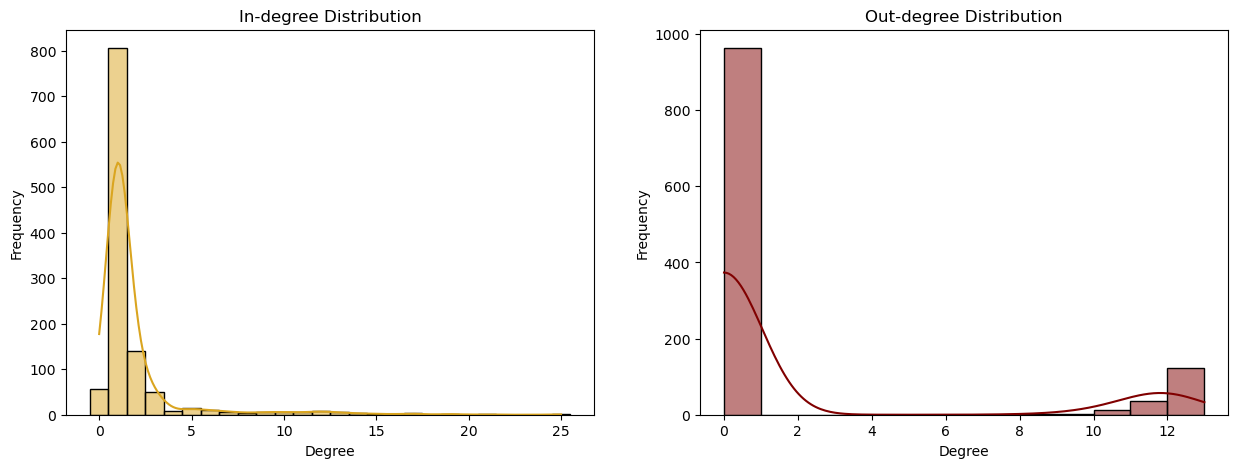

In [74]:
# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in K_largest.in_degree()]
out_degrees = [d for n, d in K_largest.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

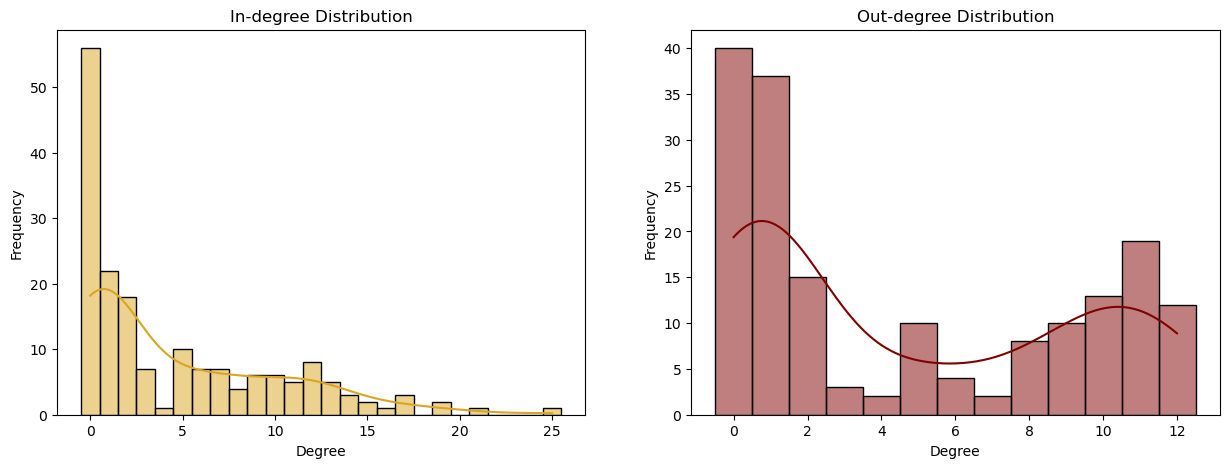

In [75]:
# Make a copy of the graph
L = K_largest.copy()

# Remove the nodes with out-degree = 0
nodes_to_remove = [node for node, out_degree in dict(L.out_degree()).items() if out_degree == 0]
L.remove_nodes_from(nodes_to_remove)

# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in L.in_degree()]
out_degrees = [d for n, d in L.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Define bin range for out-degrees
binrange = (min(out_degrees) - 0.5, max(out_degrees) + 0.5)

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth, binrange=binrange)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Print top 5 in and out-degree movies.

In [76]:
# Top 5 nodes with highest in-degree with its genre and rating
in_degrees = dict(L.in_degree())
top_5_indegree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest in-degree:")
for node, indegree in top_5_indegree:
    print(f"{node} (In-degree: {indegree})")
    print(f"    Genres: {L.nodes[node].get('Genres')}")
    print(f"    Rating: {L.nodes[node].get('Rating')}")

Top 5 nodes with highest in-degree:
Daniel the Wizard (In-degree: 25)
    Genres: Comedy, Crime, Fantasy, Music 
    Rating: 1.2 
From Justin to Kelly (In-degree: 21)
    Genres: Comedy, Music, Musical, Romance 
    Rating: 1.9 
Cosmic Sin (In-degree: 19)
    Genres: Action, Sci-Fi 
    Rating: 2.5 
Pledge This! (In-degree: 19)
    Genres: Comedy 
    Rating: 1.7 
Who's Your Caddy? (In-degree: 17)
    Genres: Comedy, Sport 
    Rating: 2.3 


In [77]:
# Top 5 nodes with highest out-degree with its genre and rating
out_degrees = dict(L.out_degree())
top_5_outdegree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest out-degree:")
for node, outdegree in top_5_outdegree:
    print(f"{node} (Out-degree: {outdegree})")
    print(f"    Genres: {L.nodes[node].get('Genres')}")
    print(f"    Rating: {L.nodes[node].get('Rating')}")

Top 5 nodes with highest out-degree:
The Human Centipede III (Final Sequence) (Out-degree: 12)
    Genres: Comedy, Horror 
    Rating: 2.7 
Meet the Spartans (Out-degree: 12)
    Genres: Comedy, Fantasy 
    Rating: 2.8 
The Starving Games (Out-degree: 12)
    Genres: Adventure, Comedy, Sci-Fi 
    Rating: 3.2 
Epic Movie (Out-degree: 12)
    Genres: Adventure, Comedy, Fantasy 
    Rating: 2.4 
Date Movie (Out-degree: 12)
    Genres: Comedy, Romance 
    Rating: 2.8 


Make undirected network.

Number of nodes: 1138
Number of edges: 1738


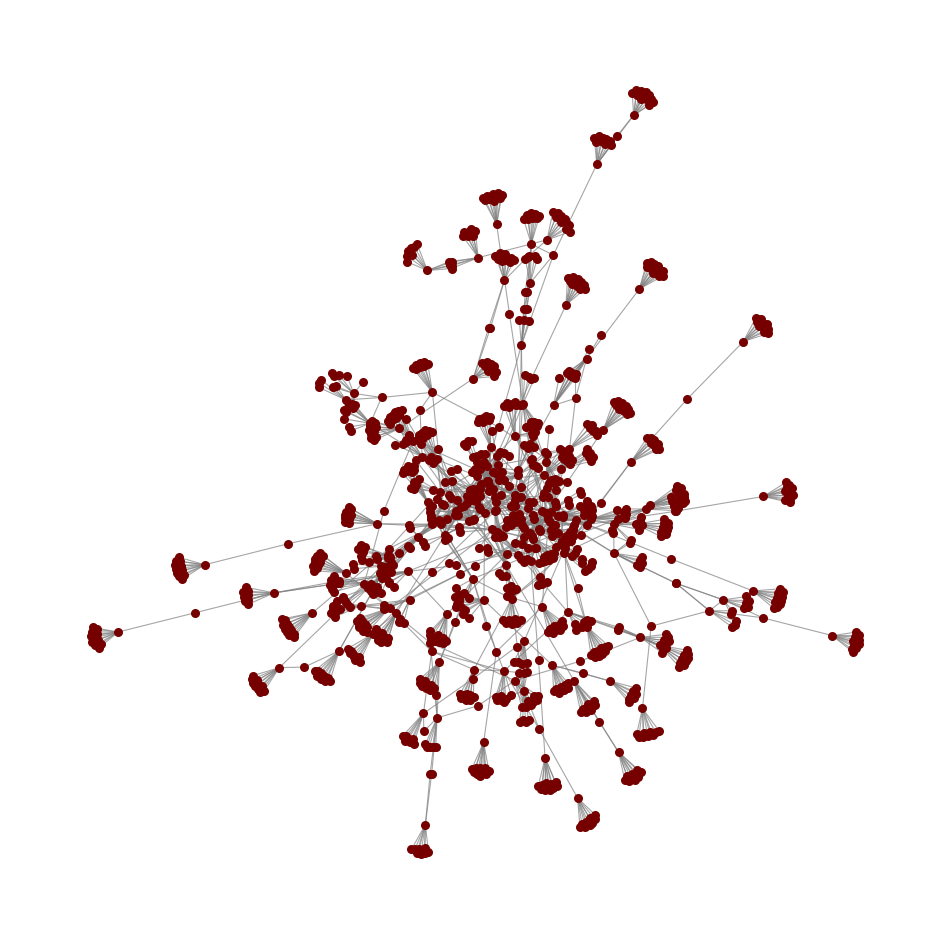

In [12]:
# Make undirected graph
M = K_largest.to_undirected()

# Num of nodes and edges
print("Number of nodes:", M.number_of_nodes())
print("Number of edges:", M.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(M, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(M, pos, edge_color='gray', alpha=0.7, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color='#760000', node_size=30)

# plt.title('Top Movies Undirected', fontsize=15)
plt.axis('off')
plt.show()

In [13]:
# Check if the undirected graph has still attributes
sample_node = "After"
if sample_node in M.nodes:
    # Print the metadata of the node in one line each
    for key, value in M.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: After 
Rating: 5.3 
Top 250 Rank: N/A 
Duration: 105 
Release Date: 11 Apr 2019 (Denmark) 
Genres: Drama, Romance 
Director: Jenny Gage 
Actors: Josephine Langford, Hero Fiennes Tiffin, Khadijha Red Thunder, Dylan Arnold, Shane Paul McGhie, Samuel Larsen, Inanna Sarkis, Selma Blair, Pia Mia, Swen Temmel 
Languages: English 
Description: Based on Anna Todd's novel, AFTER follows Tessa (Langford), a dedicated student, dutiful daughter, and loyal girlfriend to her high-school sweetheart, as she enters her first semester in college armed with grand ambitions for her future. Her guarded world opens up when she meets the dark, mysterious Hardin Scott (Tiffin), a magnetic, brooding rebel who makes her question all she thought she knew about herself and what she wants from life. 
Plot: ['A young woman falls for a guy with a dark secret and the two embark on a rocky relationship. Based on the novel by Anna Todd.', "Based on Anna Todd's novel, AFTER follows Tessa (Langford), a dedicated s

Make communities:
- Genre partition

In [80]:
# Create a dictionary to hold the partition
genre_partition_M = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in M.nodes(data=True):
    # Get the 'Genres' attribute and split it into a list, if present
    genres = data.get("Genres", "")  # Default to an empty string if 'Genres' is missing
    genres_list = [g.strip() for g in genres.split(",")] if genres else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_genre = genres_list[0] if genres_list else None
    
    # Add node to the appropriate community in the partition
    if first_genre not in genre_partition_M:
        genre_partition_M[first_genre] = []
    genre_partition_M[first_genre].append(node)

print("Total number of genres:", len(genre_partition_M), "\n")
for genre, nodes in genre_partition_M.items():
    print(f"{genre}: {len(nodes)} nodes")

Total number of genres: 19 

Comedy: 254 nodes
Action: 341 nodes
Drama: 133 nodes
Crime: 53 nodes
Adventure: 34 nodes
Animation: 16 nodes
Horror: 217 nodes
Fantasy: 11 nodes
Short: 28 nodes
Sci-Fi: 4 nodes
Documentary: 20 nodes
Talk-Show: 1 nodes
None: 6 nodes
Thriller: 4 nodes
Biography: 9 nodes
Mystery: 4 nodes
Family: 1 nodes
Music: 1 nodes
Game-Show: 1 nodes


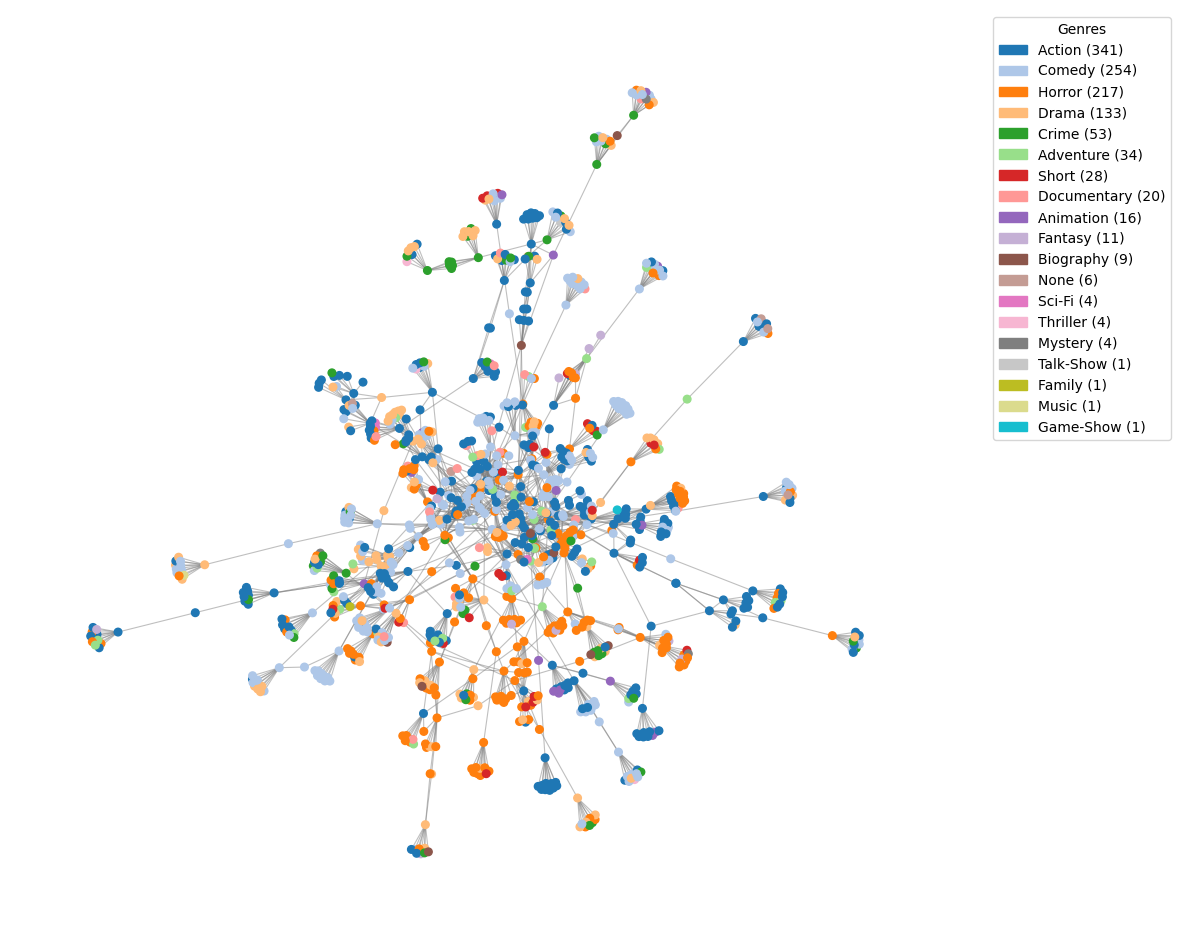

In [83]:
# Sort genres by the number of nodes, descending
sorted_genres = sorted(genre_partition_M.items(), key=lambda x: len(x[1]), reverse=True)

# Create a color map for each genre based on the sorted order
genre_to_color = {genre: plt.cm.tab20.colors[i % 20] for i, (genre, _) in enumerate(sorted_genres)}

# Create a list of colors for the nodes based on their genre
node_colors = []
for node in M.nodes:
    # Assign the corresponding color, default to "Unknown"
    assigned_color = "gray"  # Default to gray for nodes not matching any genre
    for genre, nodes in genre_partition_M.items():
        if node in nodes:
            assigned_color = genre_to_color[genre]
            break
    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(M, seed=42)  # Layout for consistent positioning

nx.draw_networkx_edges(M, pos, edge_color="gray", alpha=0.5, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color=node_colors, node_size=30)

# Create a sorted legend
legend_handles = [
    mpatches.Patch(color=genre_to_color[genre], label=f"{genre} ({len(nodes)})")
    for genre, nodes in sorted_genres
]
plt.legend(handles=legend_handles, title="Genres", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.axis("off")
plt.show()


Calculate the modularity of the genre-based partition.

In [87]:
# Calculate L (total links) in the entire network
L = M.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in genre_partition_M.values():
    subgraph = M.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.4116320890512089


In [89]:
# Modularity using NetworkX
modularity_genre2 = nx.algorithms.community.modularity(M, [set(nodes) for nodes in genre_partition_M.values()])
print("Modularity of the genre-based partition (networkX formula):", modularity_genre2)

Modularity of the genre-based partition (networkX formula): 0.25284624735652395


- Director partition

In [93]:
# Create a dictionary to hold the partition
director_partition_M = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in M.nodes(data=True):
    # Get the 'Directors' attribute and split it into a list, if present
    directors = data.get("Director", "")  # Default to an empty string if 'Genres' is missing
    directors_list = [g.strip() for g in directors.split(",")] if directors else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_director = directors_list[0] if directors_list else None
    
    # Add node to the appropriate community in the partition
    if first_director not in director_partition_M:
        director_partition_M[first_director] = []
    director_partition_M[first_director].append(node)

print("Total number of directors:", len(director_partition_M), "\n")
for director, nodes in director_partition_M.items():
    print(f"{director}: {len(nodes)} nodes")

Total number of directors: 778 

Deon Taylor: 2 nodes
Michael Tiddes: 4 nodes
Benny Boom: 1 nodes
Christopher Erskin: 1 nodes
Scott Zabielski: 1 nodes
George Ratliff: 1 nodes
Malcolm D. Lee: 3 nodes
M. Night Shyamalan: 1 nodes
Leslie Small: 1 nodes
Tim Story: 1 nodes
D-Shot: 1 nodes
Nick Cannon: 1 nodes
James Foley: 2 nodes
Sam Taylor-Johnson: 1 nodes
None: 81 nodes
Drake Doremus: 1 nodes
Jenny Gage: 1 nodes
Barbara Bialowas: 3 nodes
Roger Kumble: 1 nodes
Castille Landon: 3 nodes
Bill Condon: 2 nodes
Jeff Wadlow: 2 nodes
Shûsuke Kaneko: 1 nodes
McG: 3 nodes
Shinsuke Sato: 1 nodes
Vincenzo Natali: 1 nodes
Jonathan Demme: 1 nodes
James DeMonaco: 1 nodes
Ciarán Foy: 2 nodes
Keenen Ivory Wayans: 4 nodes
Paris Barclay: 1 nodes
Brian Robbins: 2 nodes
Raja Gosnell: 1 nodes
Mike Leigh: 1 nodes
John Whitesell: 1 nodes
David Zucker: 4 nodes
James Isaac: 1 nodes
Adam Marcus: 1 nodes
John Carl Buechler: 3 nodes
Rob Hedden: 1 nodes
Tom McLoughlin: 1 nodes
Danny Steinmann: 1 nodes
Ronny Yu: 1 nodes


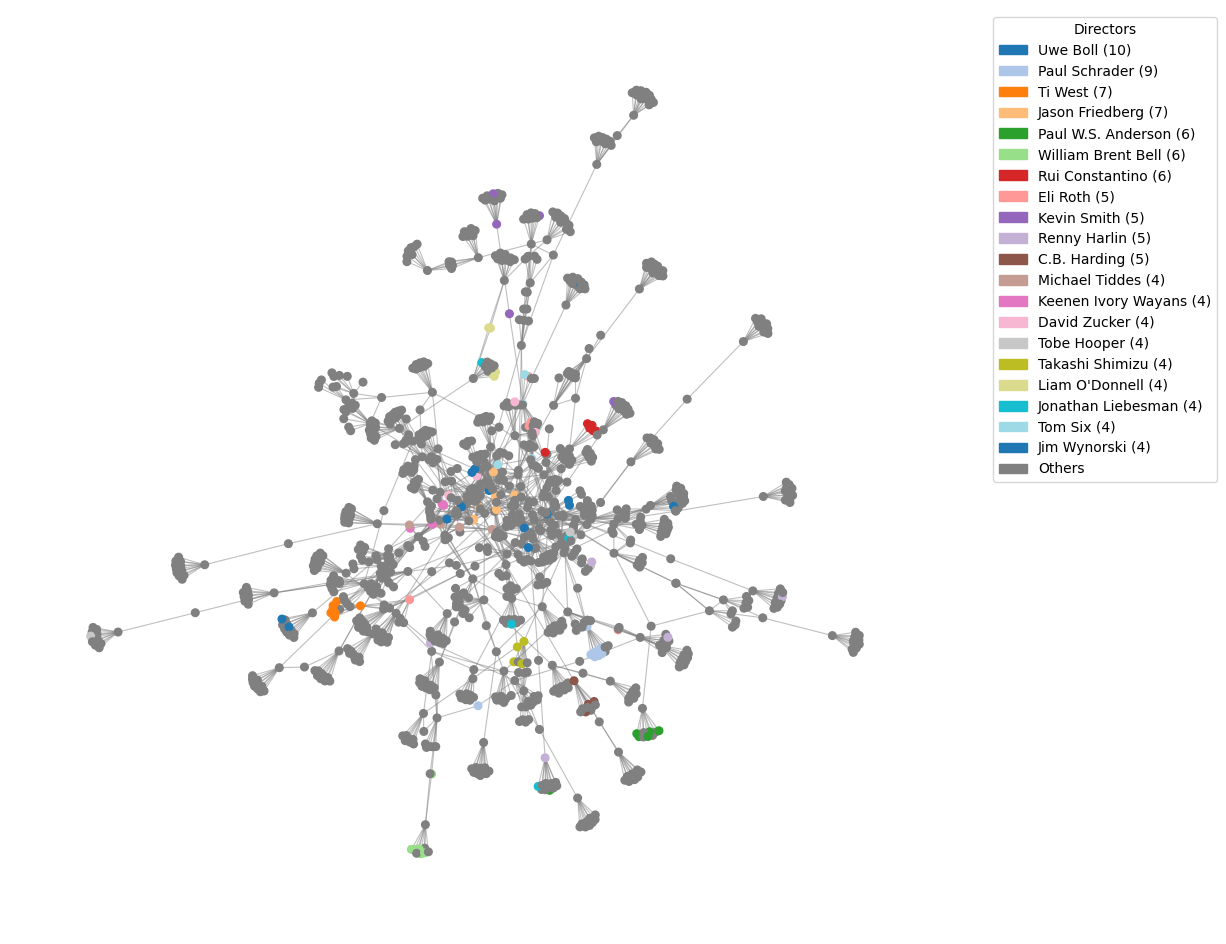

In [94]:
# Get the top 20 directors based on the number of movies (nodes), excluding 'None' or missing directors
top_20_directors = sorted(
    [(director, nodes) for director, nodes in director_partition_M.items() if director != "None" and director is not None],
    key=lambda x: len(x[1]), reverse=True
)[:20]

# Create a color map for the top 20 directors, excluding the gray color from tab20
# `tab20` has 20 colors, and we will avoid using the gray color.
tab20_colors = list(plt.cm.tab20.colors)  # Get all 20 colors
tab20_colors.remove(plt.cm.tab20.colors[14])  # Remove the gray color (index 14 in tab20)

# Create a color map for the top 20 directors using the remaining colors
director_to_color = {director: tab20_colors[i % len(tab20_colors)] for i, (director, _) in enumerate(top_20_directors)}

# Add a color for "Others" category using gray
others_color = 'gray'

# Create a list to store the color of each node based on its director
node_colors = []
for node in M.nodes:
    # Find the director of the current node by checking the partition_director dictionary
    assigned_color = others_color  # Default to "Others" for nodes without a top 20 director
    director = None  # Initialize to None (missing director)
    
    # Check the director partition and see if the node has a director
    for dir, nodes in director_partition_M.items():
        if node in nodes:
            director = dir
            break
    
    if director == "None" or director is None:  # If director is "None" or missing, assign to "Others"
        assigned_color = others_color
    elif director in director_to_color:  # If director is in top 20, assign the corresponding color
        assigned_color = director_to_color[director]
    else:  # If director is not in top 20, assign to "Others"
        assigned_color = others_color

    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(M, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(M, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color=node_colors, node_size=30)

# Create a legend for the top 20 directors and "Others"
legend_handles = [
    mpatches.Patch(color=director_to_color[director], label=f"{director} ({len(nodes)})")
    for director, nodes in top_20_directors
]
legend_handles.append(mpatches.Patch(color=others_color, label="Others"))

# Add the legend
plt.legend(handles=legend_handles, title="Directors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove axis
plt.axis('off')

# Display the plot
plt.show()


Calculate modularity of the director based communities.

In [95]:
# Calculate L (total links) in the entire network
L = M.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_director = 0
for community in director_partition_M.values():
    subgraph = M.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_director += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the director-based partition (formula book):", modularity_director)

Modularity of the director-based partition (formula book): 0.06026032859218103


In [96]:
# Modularity using NetworkX
modularity_director2 = nx.algorithms.community.modularity(M, [set(nodes) for nodes in director_partition_M.values()])
print("Modularity of the director-based partition (networkX formula):", modularity_director2)

Modularity of the director-based partition (networkX formula): 0.05470042149952129


- Louvain partition

In [101]:
# Compute the Louvain partition
louvain_partition_M = community_louvain.best_partition(M)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in louvain_partition_M.items():
    community_groups[community].append(node)

print("Number of communities:", len(community_groups), "\n")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Number of communities: 29 

Community 0: 60 nodes
Community 1: 13 nodes
Community 2: 42 nodes
Community 3: 74 nodes
Community 4: 37 nodes
Community 6: 44 nodes
Community 7: 55 nodes
Community 9: 55 nodes
Community 10: 77 nodes
Community 11: 13 nodes
Community 13: 65 nodes
Community 26: 48 nodes
Community 16: 68 nodes
Community 17: 74 nodes
Community 18: 12 nodes
Community 20: 15 nodes
Community 21: 51 nodes
Community 22: 30 nodes
Community 23: 31 nodes
Community 24: 13 nodes
Community 25: 53 nodes
Community 14: 74 nodes
Community 27: 12 nodes
Community 28: 23 nodes
Community 15: 24 nodes
Community 19: 29 nodes
Community 5: 13 nodes
Community 8: 22 nodes
Community 12: 11 nodes


C:\Users\Alba\AppData\Local\Temp\ipykernel_20736\2040966410.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors


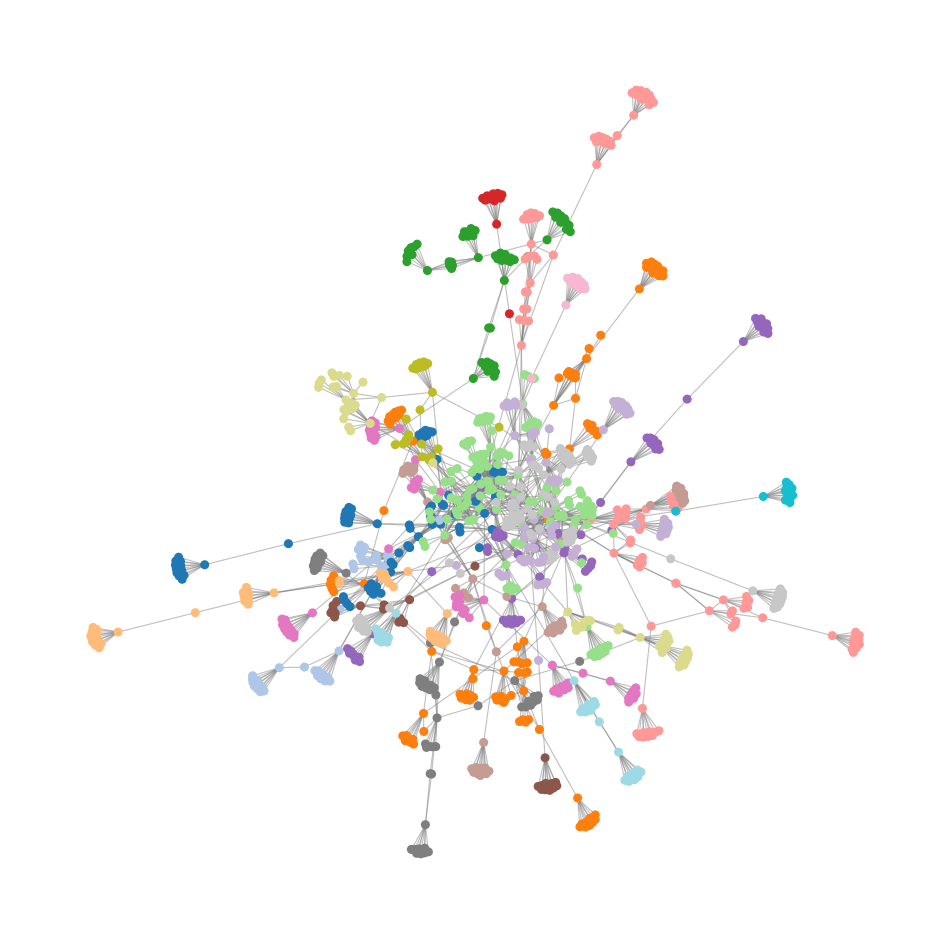

In [103]:
# Assign a unique color to each community
num_communities = len(community_groups)
color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors
community_to_color = {community: color_palette(i) for i, community in enumerate(community_groups.keys())}

# Create a list of colors for each node based on its community
node_colors = [community_to_color[louvain_partition_M[node]] for node in M.nodes]

# Plot the graph with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(M, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(M, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color=node_colors, node_size=30)

# # Add a title
# plt.title("Communities in Top Movies (Louvain Method)", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()

Calculate modularity of the director based communities.

In [104]:
# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(louvain_partition_M, M)
print("Modularity of Louvain partition:", modularity_louvain)

Modularity of Louvain partition: 0.85083627862138


Calculate confussion matrix of genre partition vs louvain partition.

In [14]:
# Modify the nodes info to get it as list instead of string
M2 = nx.Graph(M)

# Modify the nodes to have lists of genres and directors
for node in M2.nodes:
    # Get the current node data
    data = M2.nodes[node]
    
    # Get the genres and directors as strings
    genres = data.get("Genres", "")
    directors = data.get("Director", "")
    actors = data.get("Actors", "")
    producers = data.get("Producer", "")
    production_companies = data.get("Production Companies", "")
    
    # Split the strings into lists
    genres_list = [g.strip() for g in genres.split(",")] if genres else []
    directors_list = [d.strip() for d in directors.split(",")] if directors else []
    actors_list = [a.strip() for a in actors.split(",")] if actors else []
    producers_list = [p.strip() for p in producers.split(",")] if producers else []
    production_companies_list = [pc.strip() for pc in production_companies.split(",")] if production_companies else []

    # Update the node data with the lists
    data["Genres"] = genres_list
    data["Director"] = directors_list
    data["Actors"] = actors_list
    data["Producer"] = producers_list
    data["Production Companies"] = production_companies_list

# Check the updated node data for a sample node
sample_node = "A Beautiful Mind"
if sample_node in M2.nodes:
    # Print the metadata of the node in one line each
    for key, value in M2.nodes[sample_node].items():
        print(f"{key}: {value}")

In [108]:
# Get the 10 most common genres
most_common_genres = sorted(genre_partition_M.keys(), key=lambda g: len(genre_partition_M[g]), reverse=True)[:10]

# Get 10 biggest communities
community_count = pd.Series(louvain_partition_M).value_counts()
most_common_communities = community_count.nlargest(10).index.tolist()

# Confusion matrix
D_matrix_M = np.zeros((len(most_common_genres), len(most_common_communities)), dtype=int)

for node in M2.nodes():
    # Get the genres directly from the node attributes
    node_genres = M2.nodes[node]['Genres']  # List of genres for the node
    node_community = louvain_partition_M[node]  # Community ID for the node
    
    # Check if the community is one of the largest ones
    if node_community in most_common_communities:
        community_index = most_common_communities.index(node_community)
        
        # Count all genres of this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                D_matrix_M[genre_index, community_index] += 1  # Increment the count in the matrix

# Display the confusion matrix
D_df = pd.DataFrame(D_matrix_M, index=most_common_genres, columns=most_common_communities)
print("Confusion Matrix (Genres vs Communities):")
print(D_df)


Confusion Matrix (Genres vs Communities):
             10  17  14  3   16  13  0   9   7   25
Action       22  28  35   5   7  52  12  16  19   4
Comedy       38  46  49   6   3   9  52  16   4   4
Horror       22   8  12  60  50  14  15  15   3  35
Drama        13  14  34  33  16  12   8  21  36  20
Crime         6  15  13   8   1  14  13  15  21   6
Adventure    13  19   5   7   5  26   3  11   9   2
Short         2   2   1   1   2   1   1   1   0   3
Documentary   6   0   0   1   0   1   1   2   2   0
Animation     1   1   0   1   0   3   1   0   0   0
Fantasy      14  15   3   8   3  17   6   9   1   3


# Sentiment analysis of both TOP and BOTTOM
Create dictionary: 

1. Input Data: The process starts with a CSV file (top_250_scraped_keywords_with_names.csv) containing movie names and their associated keywords.

2. Genre Information: Each movie in the dataset is linked to a graph (G2), where its genres are stored. For example, a movie might belong to genres like Drama and Thriller.

3. Counting Keywords by Genre: For every movie:
    - Its keywords are extracted and split into a list.
    - Each keyword is counted under the genres associated with that movie. 
    - For example, if the keyword "prison" appears in a movie tagged with Drama and Thriller, it increases the count of Drama and Thriller for the keyword.

4. Building the Dictionary: A dictionary is constructed where:
    - Each keyword is a key.
    - The value is another dictionary with genres as keys and their respective counts as values.
    - This dictionary is then converted into a tabular format (DataFrame) for easier analysis and storage.

5. Output: The final dictionary is saved as a CSV file (top_250_dictionary.csv) for further use.

Purpose: This dictionary enables us to associate keywords with the genres they frequently occur in, helping in genre prediction and analysis for movies based on their keywords.

| **Keyword** | **Drama** | **Action** | **Thriller** | **Romance** |
|-------------|-----------|------------|--------------|-------------|
| **prison**  | 17.0      | 3.0        | 5.0          | 0.0         |
| **love**    | 10.0      | 0.0        | 0.0          | 10.0        |
| **survival**| 0.0       | 10.0       | 10.0         | 0.0         |


First for the top movies.

In [24]:
# Load the CSV containing movie names and keywords
keywords_df = pd.read_csv("top_250_scraped_keywords_with_names.csv")

# Initialize a dictionary to store keyword counts by genre
keyword_genre_counts = defaultdict(lambda: defaultdict(int))  # {keyword: {genre: count}}

# Loop through each movie in the CSV
for _, row in keywords_df.iterrows():
    movie_name = row['Name']  # Name of the movie
    keywords = row['keywords'].split(", ")  # List of keywords for the movie

    # Get the genres associated with the movie from G2
    if movie_name in G2.nodes:
        genres = G2.nodes[movie_name].get("Genres", [])  # Get genres as a list
    else:
        print(f"Movie '{movie_name}' not found in G2. Skipping...")
        continue  # Skip if the movie is not in the graph

    # Count each keyword under the appropriate genres
    for keyword in keywords:
        for genre in genres:
            keyword_genre_counts[keyword][genre] += 1

# Create a list of rows to build the DataFrame
rows = []
for keyword, genre_counts in keyword_genre_counts.items():
    row = {"Keyword": keyword}
    row.update(genre_counts)  # Add genre counts for this keyword
    rows.append(row)

# Convert the list of dictionaries into a DataFrame
genre_counts_df = pd.DataFrame(rows)

# Fill missing values with 0 (keywords that don't appear in some genres)
genre_counts_df.fillna(0, inplace=True)

# Save the resulting DataFrame to a new CSV file
genre_counts_df.to_csv("top_250_dictionary.csv", index=False)


Now with the bottom movies.

In [ ]:
# Load the CSV containing movie names and keywords
keywords_df = pd.read_csv("bottom_250_scraped_keywords_with_names.csv")

# Initialize a dictionary to store keyword counts by genre
keyword_genre_counts = defaultdict(lambda: defaultdict(int))  # {keyword: {genre: count}}

# Skip count
skip = 0

# Loop through each movie in the CSV
for _, row in keywords_df.iterrows():
    movie_name = row['Name']  # Name of the movie
    keywords = row['keywords'].split(", ")  # List of keywords for the movie

    # Get the genres associated with the movie from G2
    if movie_name in M2.nodes:
        genres = M2.nodes[movie_name].get("Genres", [])  # Get genres as a list
    else:
        print(f"Movie '{movie_name}' not found in G2. Skipping...")
        skip +=1
        continue  # Skip if the movie is not in the graph

    # Count each keyword under the appropriate genres
    for keyword in keywords:
        for genre in genres:
            keyword_genre_counts[keyword][genre] += 1

# Create a list of rows to build the DataFrame
rows = []
for keyword, genre_counts in keyword_genre_counts.items():
    row = {"Keyword": keyword}
    row.update(genre_counts)  # Add genre counts for this keyword
    rows.append(row)

# Convert the list of dictionaries into a DataFrame
genre_counts_df = pd.DataFrame(rows)

# Fill missing values with 0 (keywords that don't appear in some genres)
genre_counts_df.fillna(0, inplace=True)

# Save the resulting DataFrame to a new CSV file
genre_counts_df.to_csv("bottom_250_dictionary.csv", index=False)

# Total of skipped movies
print(f"Total of skipped movies: {skip}")

Join both dictionaries into one 'merged_dictionary.csv' containing all the keywords.

In [ ]:
# Join top movies dictionary with the bottom movies dictionary
top_movies_df = pd.read_csv("top_250_dictionary.csv")
bottom_movies_df = pd.read_csv("bottom_250_dictionary.csv")

# Ensure both DataFrames have all the same columns
all_genres = set(top_movies_df.columns).union(set(bottom_movies_df.columns))
all_genres.remove('Keyword')  # Exclude the "Keyword" column from genres

# Add missing genres as columns with default value 0
for genre in all_genres:
    if genre not in top_movies_df:
        top_movies_df[genre] = 0.0
    if genre not in bottom_movies_df:
        bottom_movies_df[genre] = 0.0

# Merge the DataFrames on the "Keyword" column
merged_df = pd.concat([top_movies_df, bottom_movies_df], axis=0, ignore_index=True)

# Group by "Keyword" and sum the values for duplicate keywords
merged_df = merged_df.groupby('Keyword', as_index=False).sum()

# Save the result to a new CSV file
merged_df.to_csv('merged_dictionary.csv', index=False)

# Preview the merged DataFrame
print(merged_df)

Now we make the genre mapping of the keywords.

The create_keyword_genre_mapping function takes a DataFrame (genre_df) containing keywords and their scores for different genres and creates a mapping where each keyword is associated with the genre(s) that have the highest score for it. Here's how it works:

1. Iterating Through Rows: The function loops through each row of the DataFrame. Each row represents a keyword and its scores across various genres.

2. Finding the Maximum Score: For each row, the function finds the maximum score across all genres. This score indicates which genre(s) the keyword is most strongly associated with.

3. Identifying Genres with the Maximum Score: The genres that have the maximum score for the keyword are identified. If there’s a tie (two or more genres have the same score), all such genres are included.

4. Storing the Mapping: The keyword is stored as a key in the dictionary, with its value being a list of genres that have the highest score.

Below is an example:

If we have the following dictionary:

| **Keyword** | **Drama** | **Action** | **Thriller** | **Romance** |
|-------------|-----------|------------|--------------|-------------|
| **prison**  | 17.0      | 3.0        | 5.0          | 0.0         |
| **love**    | 10.0      | 0.0        | 0.0          | 10.0        |
| **survival**| 0.0       | 10.0       | 10.0         | 0.0         |

The associated genres for each keyword would be:
- **prison**: Drama
- **love** : Drama, Romance
- **survival**: Action, Thriller


In [ ]:
def create_keyword_genre_mapping(genre_df):
    keyword_genre_mapping = {}
    
    # Loop through each row of the genre_df
    for _, row in genre_df.iterrows():
        keyword = row['Keyword']
        
        # Get the maximum score across all genres for this keyword
        max_score = row[1:].max()  # Get the maximum score (ignores the 'Keyword' column)

        # Find the genres that have the max score
        genres_with_max_score = row[1:][row[1:] == max_score].index.tolist()
        
        # Store the keyword and its associated genres
        keyword_genre_mapping[keyword] = genres_with_max_score
    
    return keyword_genre_mapping

# Example usage with your genre_df
keyword_genre_mapping = create_keyword_genre_mapping(merged_df)

# Print the mapping for a sample keyword
sample_keyword = "scientist"
if sample_keyword in keyword_genre_mapping:
    print(f"Genres associated with '{sample_keyword}': {keyword_genre_mapping[sample_keyword]}")
else:
    print(f"'{sample_keyword}' not found in the keyword-genre mapping.")


Genres associated with 'scientist': ['Sci-Fi']


From now on, we continue only with the TOP to not mix and then will do the bottom and compare both.

Extracting the synopses of each movie.

In [15]:
# Path to the directory containing text files
dir_path = "top_net_movies_info"

# Function to extract the synopsis from a file
def extract_synopsis(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Use a regular expression to extract the synopsis (assuming it's between "Synopsis:" and "]")
    match = re.search(r'Synopsis:\s*\[(.*?)\]', content, re.DOTALL)
    if match:
        synopsis = match.group(1)
        return synopsis
    else:
        return ""

# Get a list of all files in the directory
files = os.listdir(dir_path)

# Extract synopses from each file
synopses = {}
for file in files:
    file_path = os.path.join(dir_path, file)
    if os.path.isfile(file_path):
        synopsis = extract_synopsis(file_path)
        # You can associate the synopsis with the movie name, here we use the file name as the movie name
        movie_name = os.path.splitext(file)[0]
        synopses[movie_name] = synopsis

# Preview the extracted synopses with a example
print(synopses['Alien'])


'Out in deep space, a Weyland-Yutani space probe finds and investigates the wreckage of the USCSS Nostromo (the ship from the original Alien), retrieving a small organic object. Transferred into a larger vessel, the object is opened and part of it removed from the room; the other part is focused on, revealing the shape of a Xenomorph within.Rain Carradine, an orphan, works with her adoptive brother Andy, a damaged synthetic human reprogrammed by Rain\'s father in order to keep her safe, at a mining colony on the planet Jackson\'s Star. Having worked the contracted amount of hours requires, Rain wants to leave the planet for a new life on the distant Yvaga III; however, the Weyland-Yutani clerk instead doubles her contracted time, and an attack on Andy by three teenage punks prevents her from arguing further.Shortly after, Rain\'s ex-boyfriend Tyler contacts her and asks to meet at their ship, the hauler Corbelan IV. Also present are Tyler\'s sister Kay, his younger cousin Bjorn, and th

Cleaning the synopses.

In [16]:
# Function to clean and preprocess the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Clean all synopses
for movie, synopsis in synopses.items():
    synopses[movie] = clean_text(synopsis)

# Preview the cleaned synopses in a example
print(synopses['Alien'])


out in deep space a weylandyutani space probe finds and investigates the wreckage of the uscss nostromo the ship from the original alien retrieving a small organic object transferred into a larger vessel the object is opened and part of it removed from the room the other part is focused on revealing the shape of a xenomorph withinrain carradine an orphan works with her adoptive brother andy a damaged synthetic human reprogrammed by rains father in order to keep her safe at a mining colony on the planet jacksons star having worked the contracted amount of hours requires rain wants to leave the planet for a new life on the distant yvaga iii however the weylandyutani clerk instead doubles her contracted time and an attack on andy by three teenage punks prevents her from arguing furthershortly after rains exboyfriend tyler contacts her and asks to meet at their ship the hauler corbelan iv also present are tylers sister kay his younger cousin bjorn and their pilot bjorns adopted sister nava

Calculate the percentage representation of different genres in a movie's synopsis based on genre-related keywords. 
Each keyword can be associated with one or more genres, and the calculation treats multi-genre keywords as contributing to each genre independently. 
Here's how it works:

1. **Keyword-Genre Mapping**:
   - A predefined dictionary links specific keywords to genres.
   - Example:
     ```python
     keyword_genre_mapping = {
         'alien': ['Sci-Fi', 'Horror'],
         'spaceship': ['Sci-Fi'],
         'terrorizing': ['Horror'],
         'masterpiece': ['Drama'],
     }
     ```

2. **Process Each Movie Synopsis**:
   - Clean the synopsis text (e.g., remove punctuation, convert to lowercase).
   - Identify unique words in the synopsis.
   - For each word, check if it's in the `keyword_genre_mapping`. If it is:
     - Add `1` to the count of each genre associated with the word.
     - Increment the total keyword count by the number of associated genres.

3. **Calculate Percentages**:
   - For each genre, calculate its percentage as:
   
     $\text{Percentage of Genre} = \left( \frac{\text{Genre Count}}{\text{Total Keywords}} \right) \times 100$

   - This ensures that all genre contributions sum to 100%.



In [36]:
def calculate_genre_percentages(synopsis, keyword_genre_mapping):
    # Clean the synopsis and split into words
    cleaned_synopsis = clean_text(synopsis)
    words = cleaned_synopsis.split()  # All words in the synopsis (not unique)
    #words = set(cleaned_synopsis.split())  # Unique words in the synopsis
    
    genre_counts = Counter()  # To store genre counts
    total_keywords = 0  # To store the total number of genre-related keywords found
    
    # For each word in the cleaned synopsis, check if it's a keyword and if so, count it in its genres
    for word in words:
        if word in keyword_genre_mapping:
            genres = keyword_genre_mapping[word]
            total_keywords += len(genres)  # Increment total for each genre match
            for genre in genres:
                genre_counts[genre] += 1
    
    # Calculate the genre percentages
    if total_keywords == 0:  # If no genre-related keywords are found
        return {genre: 0 for genre in genre_counts}
    
    genre_percentages = {genre: (count / total_keywords) * 100 for genre, count in genre_counts.items()}
    
    return genre_percentages

# Loop through all movies and calculate their genre percentages based on their synopses
movie_genre_percentages = {}

for movie_name, synopsis in synopses.items():
    genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
    movie_genre_percentages[movie_name] = genre_percentages

# Preview the results for one movie
print(movie_genre_percentages.get('Alien', {}))


{'Drama': 33.61344537815126, 'Sci-Fi': 16.246498599439775, 'Adventure': 10.644257703081232, 'Thriller': 10.92436974789916, 'Comedy': 3.081232492997199, 'Fantasy': 2.801120448179272, 'Animation': 2.801120448179272, 'Family': 3.081232492997199, 'Biography': 1.9607843137254901, 'War': 1.9607843137254901, 'History': 1.9607843137254901, 'Western': 0.2801120448179272, 'Action': 4.761904761904762, 'Sport': 0.8403361344537815, 'Romance': 1.400560224089636, 'Mystery': 1.400560224089636, 'Crime': 0.8403361344537815, 'Horror': 1.400560224089636}


In [37]:
# Check if percentages sum 100
alien_percentages = movie_genre_percentages.get('Alien', {})
total_percentage = sum(alien_percentages.values())
print(f"Total percentage for 'Alien': {total_percentage:.2f}%")

Total percentage for 'Alien': 100.00%


Create the CSV containing the genre percentages for all the movies.

1. Initialization: Creates an empty list movie_genre_percentages to store the processed results for each movie.

2. Loop Through Synopses:For each movie, the function calculates the percentage contribution of each genre to the movie’s synopsis using the calculate_genre_percentages function.

3. Sort Genres by Percentage: The genres are sorted in descending order of their percentages. This ensures that the most prominent genres appear first.

4. Organize Data for Each Movie: For each movie:
    - Top Genre: The genre with the highest percentage.
    - Top Percentage: The percentage value of the top genre.
    - All Genres: A string representation of all genres and their percentages in descending order (e.g., "Drama: 40.00%, Romance: 30.00%").

5. Save to a CSV File: The data is converted into a DataFrame and saved as a CSV file with the name provided in output_file.

Below there is an example:

| Movie          | Top Genre | Top Percentage | All Genres                                     |
|----------------|-----------|----------------|-----------------------------------------------|
| Alien          | Sci-Fi    | 60.00          | Sci-Fi: 60.00%, Action: 30.00%, Thriller: 10.00% |
| Titanic        | Romance   | 70.00          | Romance: 70.00%, Drama: 20.00%, History: 10.00% |
| The Matrix     | Sci-Fi    | 50.00          | Sci-Fi: 50.00%, Action: 40.00%, Thriller: 10.00% |
| Shawshank Redemption | Drama     | 80.00          | Drama: 80.00%, Crime: 15.00%, Biography: 5.00% |
| Inception      | Thriller  | 50.00          | Thriller: 50.00%, Sci-Fi: 40.00%, Action: 10.00% |


In [ ]:
# Calculate genre percentages and organize from top to bottom for each film
def process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file):
    movie_genre_percentages = []

    for movie_name, synopsis in synopses.items():
        # Calculate percentages for the movie
        genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
        # Sort genres by percentage in descending order
        sorted_genres = sorted(genre_percentages.items(), key=lambda x: x[1], reverse=True)
        # Prepare data for saving
        movie_genre_percentages.append({
            "Movie": movie_name,
            "Top Genre": sorted_genres[0][0] if sorted_genres else None,  # Highest percentage genre
            "Top Percentage": sorted_genres[0][1] if sorted_genres else 0,  # Highest percentage
            "All Genres": ", ".join([f"{genre}: {percentage:.2f}%" for genre, percentage in sorted_genres])  # Full list
        })

    # Convert to DataFrame and save
    result_df = pd.DataFrame(movie_genre_percentages)
    result_df.to_csv(output_file, index=False)
    print(f"Genre percentages saved to {output_file}")

# Run the function and save the results
output_file = "movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file)

Genre percentages saved to movie_genre_percentages.csv


Now we go with the BOTTOM movies.

In [21]:
# Path to the directory containing text files
dir_path = "bottom_net_movies_info"

# Function to extract the synopsis from a file
def extract_synopsis(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Use a regular expression to extract the synopsis (assuming it's between "Synopsis:" and "]")
    match = re.search(r'Synopsis:\s*\[(.*?)\]', content, re.DOTALL)
    if match:
        synopsis = match.group(1)
        return synopsis
    else:
        return ""

# Get a list of all files in the directory
files = os.listdir(dir_path)

# Extract synopses from each file
synopses = {}
for file in files:
    file_path = os.path.join(dir_path, file)
    if os.path.isfile(file_path):
        synopsis = extract_synopsis(file_path)
        # You can associate the synopsis with the movie name, here we use the file name as the movie name
        movie_name = os.path.splitext(file)[0]
        synopses[movie_name] = synopsis

# Preview the extracted synopses with a example
print(synopses['After'])


'The movie opens with a voice-over by a teenage girl talking about how moments in your life that can define you while it shows a montage of shots of a couple spending time together. The girl says everything in her life was simple before him, and now it\'s just after.Tessa (Josephine Langford) wakes up from a dream and starts to pack her room to leave for college. She is joined by her mother, Carol (Selma Blair) and her BF (best friend), Noah (Dylan Arnold) in the kitchen downstairs. Her mother is listing off items that she thinks that Tessa will need while Tessa reminds her that she is going to college and not a survival camp. Noah interjects and says he can drive up there and drop anything off if she forgets it.The next scene shows them driving through various city settings until they get to her new University. Carol, Noah, and Tessa make their way through the crowded dorm halls looking for her new room, B-22. They open the door and are met by loud music and two girls sitting on the b

In [22]:
# Function to clean and preprocess the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Clean all synopses
for movie, synopsis in synopses.items():
    synopses[movie] = clean_text(synopsis)

# Preview the cleaned synopses in a example
print(synopses['After'])


the movie opens with a voiceover by a teenage girl talking about how moments in your life that can define you while it shows a montage of shots of a couple spending time together the girl says everything in her life was simple before him and now its just aftertessa josephine langford wakes up from a dream and starts to pack her room to leave for college she is joined by her mother carol selma blair and her bf best friend noah dylan arnold in the kitchen downstairs her mother is listing off items that she thinks that tessa will need while tessa reminds her that she is going to college and not a survival camp noah interjects and says he can drive up there and drop anything off if she forgets itthe next scene shows them driving through various city settings until they get to her new university carol noah and tessa make their way through the crowded dorm halls looking for her new room b22 they open the door and are met by loud music and two girls sitting on the bed tessa introduces herself

In [23]:
def calculate_genre_percentages(synopsis, keyword_genre_mapping):
    # Clean the synopsis and split into words
    cleaned_synopsis = clean_text(synopsis)
    words = cleaned_synopsis.split()  # All words in the synopsis (not unique)
    #words = set(cleaned_synopsis.split())  # Unique words in the synopsis
    
    genre_counts = Counter()  # To store genre counts
    total_keywords = 0  # To store the total number of genre-related keywords found
    
    # For each word in the cleaned synopsis, check if it's a keyword and if so, count it in its genres
    for word in words:
        if word in keyword_genre_mapping:
            genres = keyword_genre_mapping[word]
            total_keywords += len(genres)  # Increment total for each genre match
            for genre in genres:
                genre_counts[genre] += 1
    
    # Calculate the genre percentages
    if total_keywords == 0:  # If no genre-related keywords are found
        return {genre: 0 for genre in genre_counts}
    
    genre_percentages = {genre: (count / total_keywords) * 100 for genre, count in genre_counts.items()}
    
    return genre_percentages

# Loop through all movies and calculate their genre percentages based on their synopses
movie_genre_percentages = {}

for movie_name, synopsis in synopses.items():
    genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
    movie_genre_percentages[movie_name] = genre_percentages

# Preview the results for one movie
print(movie_genre_percentages.get('After', {}))


NameError: name 'keyword_genre_mapping' is not defined

In [ ]:
# Check if percentages sum 100
alien_percentages = movie_genre_percentages.get('After', {})
total_percentage = sum(alien_percentages.values())
print(f"Total percentage for 'After': {total_percentage:.2f}%")

In [ ]:
# Calculate genre percentages and organize from top to bottom for each film
def process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file):
    movie_genre_percentages = []

    for movie_name, synopsis in synopses.items():
        # Calculate percentages for the movie
        genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
        # Sort genres by percentage in descending order
        sorted_genres = sorted(genre_percentages.items(), key=lambda x: x[1], reverse=True)
        # Prepare data for saving
        movie_genre_percentages.append({
            "Movie": movie_name,
            "Top Genre": sorted_genres[0][0] if sorted_genres else None,  # Highest percentage genre
            "Top Percentage": sorted_genres[0][1] if sorted_genres else 0,  # Highest percentage
            "All Genres": ", ".join([f"{genre}: {percentage:.2f}%" for genre, percentage in sorted_genres])  # Full list
        })

    # Convert to DataFrame and save
    result_df = pd.DataFrame(movie_genre_percentages)
    result_df.to_csv(output_file, index=False)
    print(f"Genre percentages saved to {output_file}")

# Run the function and save the results
output_file = "bottom_movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file)


Now we make the comparison.

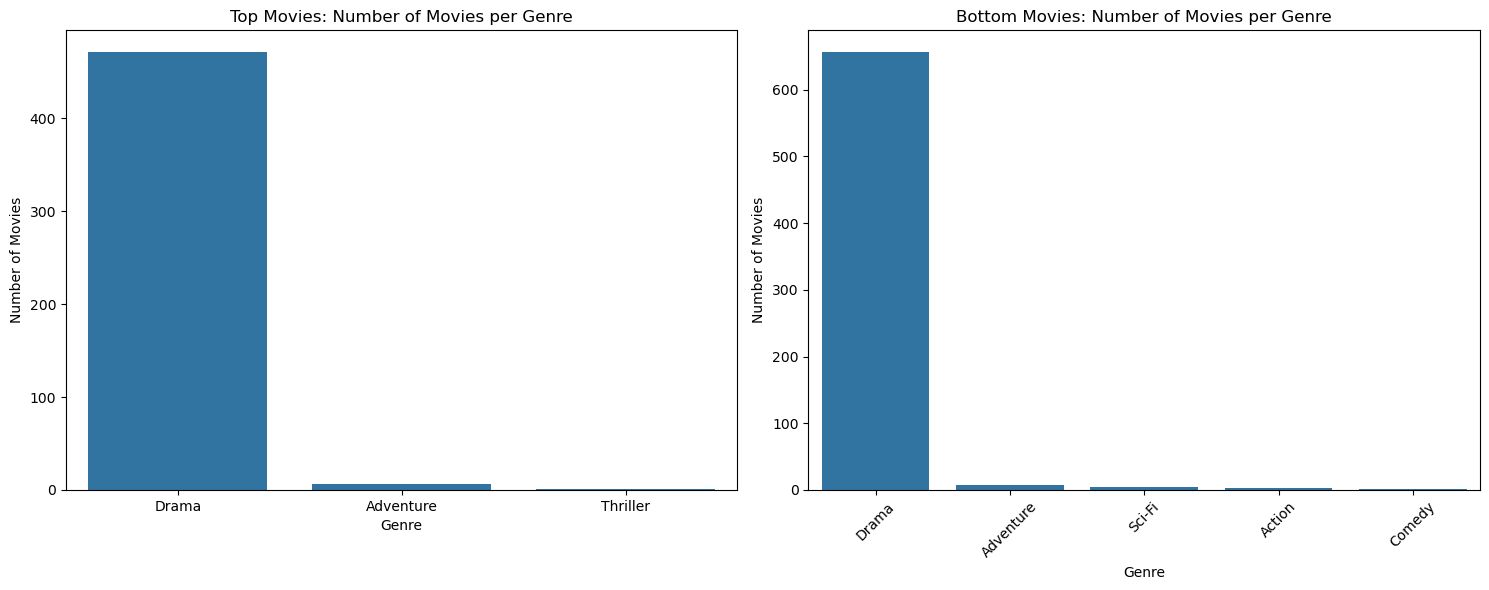

In [ ]:
# Plot the number of movies per genre
# top movies
genre_percentages_top = pd.read_csv("top_movie_genre_percentages.csv")
genre_counts_top = genre_percentages_top['Top Genre'].value_counts()

# bottom movies
genre_percentages_bottom = pd.read_csv("bottom_movie_genre_percentages.csv")
genre_counts_bottom = genre_percentages_bottom['Top Genre'].value_counts()

# Create a bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top movies
sns.barplot(x=genre_counts_top.index, y=genre_counts_top, ax=ax1)
ax1.set_title("Top Movies: Number of Movies per Genre")
ax1.set_xlabel("Genre")
ax1.set_ylabel("Number of Movies")

# Bottom movies
sns.barplot(x=genre_counts_bottom.index, y=genre_counts_bottom, ax=ax2)
ax2.set_title("Bottom Movies: Number of Movies per Genre")
ax2.set_xlabel("Genre")
ax2.set_ylabel("Number of Movies")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**NEW MAPPING COUNTING ALL GENRES FOR THE KEYWORDS!!!!**

**Step1: Normalize the Genre Values**

For each keyword in the dataset, normalize the genre values so their total adds up to **1**. This ensures that each keyword contributes proportionally to its associated genres.

Example Dataset:
| Keyword  | Drama | Biography | Crime | Thriller | Short | Action | Sci-Fi | War | Mystery | Comedy | Adventure | Fantasy | Horror |
|----------|-------|-----------|-------|----------|-------|--------|--------|-----|---------|--------|-----------|---------|--------|
| prison   | 18.0  | 5.0       | 10.0  | 5.0      | 1.0   | 2.0    | 2.0    | 4.0 | 2.0     | 4.0    | 3.0       | 1.0     | 1.0    |
| action   | 2.0   | 0.0       | 4.0   | 3.0      | 0.0   | 5.0    | 6.0    | 0.0 | 1.0     | 2.0    | 7.0       | 1.0     | 3.0    |

1. Calculate the Total for Each Keyword:  
   - **prison**: $18 + 5 + 10 + 5 + 1 + 2 + 2 + 4 + 2 + 4 + 3 + 1 + 1 = 58$
   - **action**: $2 + 0 + 4 + 3 + 0 + 5 + 6 + 0 + 1 + 2 + 7 + 1 + 3 = 34$
   
2. Normalize Each Value for Each Keyword:  
   - For **prison**:  
     - Drama: $\frac{18}{58} = 0.310$ 
     - Biography: $\frac{5}{58} = 0.086$  
     - Crime: $\frac{10}{58} = 0.172$ 
     - And so on...

   - For **action**:  
     - Drama: $\frac{2}{34} = 0.059$  
     - Biography: $\frac{0}{34} = 0.0$
     - Crime: $\frac{4}{34} = 0.118$ 
     - And so on...

Normalized Dataset:
| Keyword  | Drama  | Biography | Crime  | Thriller | Short  | Action | Sci-Fi | War   | Mystery | Comedy | Adventure | Fantasy | Horror |
|----------|--------|-----------|--------|----------|--------|--------|--------|-------|---------|--------|-----------|---------|--------|
| prison   | 0.310  | 0.086     | 0.172  | 0.086    | 0.017  | 0.034  | 0.034  | 0.069 | 0.034   | 0.069  | 0.052     | 0.017   | 0.017  |
| action   | 0.059  | 0.000     | 0.118  | 0.088    | 0.000  | 0.147  | 0.176  | 0.000 | 0.029   | 0.059  | 0.206     | 0.029   | 0.088  |


**Step 2: Process the Synopsis**
1. Split the synopsis into individual words.
2. For each word in the synopsis:
   - If it matches a keyword in the dataset, retrieve its normalized genre values.
   - Add these normalized values to the running total for each genre.

Example:

Synopsis:  *"prison action prison"*

- The word "prison" appears **twice**.
- The word "action" appears **once**.

Add Contributions for 'prison' (twice):  
- Drama: $2 \times 0.310 = 0.620$
- Biography: $2 \times 0.086 = 0.172$
- Crime: $2 \times 0.172 = 0.344$
- And so on...

Add Contributions for 'action' (once):  
- Drama: $0.059$  
- Biography: $0.000$ 
- Crime: $0.118$
- And so on...

Total Contributions:
| Genre     | Total Contribution |
|-----------|---------------------|
| Drama     | 0.620 + 0.059 = 0.679 |
| Biography | 0.172 + 0.000 = 0.172 |
| Crime     | 0.344 + 0.118 = 0.462 |
| And so on...


**Step 3: Calculate Genre Percentages**
1. Sum All Contributions:  
   $\text{Total} = 0.679 + 0.172 + 0.462 + 0.260 + 0.034 + 0.215 + 0.244 + \dots$
   
2. Calculate the Percentage for Each Genre:  
   - Drama: $\frac{0.679}{\text{Total}} \times 100$ 
   - Biography: $\frac{0.172}{\text{Total}} \times 100$ 
   - Crime: $\frac{0.462}{\text{Total}} \times 100$  
   - And so on...

Final Genre Percentages:
| Genre     | Percentage |
|-----------|------------|
| Drama     | 43.9%      |
| Biography | 12.2%      |
| Crime     | 24.4%      |
| Thriller  | 12.2%      |
| Short     | 2.4%       |
| Action    | 4.9%       |


In [18]:
# Step 1: Normalize the genre values for each keyword
def normalize_genres(df):
    normalized_mapping = {}
    for _, row in df.iterrows():
        keyword = row['Keyword']
        genre_values = row.iloc[1:]  # Exclude 'Keyword'
        genre_values = genre_values[genre_values > 0]  # Keep only non-zero genres
        total = genre_values.sum()
        normalized_mapping[keyword] = (genre_values / total).to_dict()  # Normalize
    return normalized_mapping

# Step 2: Process synopsis to calculate genre percentages
def calculate_genre_percentages(synopsis, keyword_genre_mapping):
    words = synopsis.split()  # Split synopsis into words
    genre_totals = Counter()
    
    # For each word in the synopsis
    for word in words:
        if word in keyword_genre_mapping:  # If the word is in the mapping
            for genre, value in keyword_genre_mapping[word].items():
                genre_totals[genre] += value  # Add the genre contribution
    
    # Convert totals into percentages
    total_contributions = sum(genre_totals.values())
    genre_percentages = {genre: (count / total_contributions) * 100 for genre, count in genre_totals.items()}
    return genre_percentages

# Step 3: Process all synopses and calculate genre percentage
def process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file):
    movie_genre_percentages = []

    for movie_name, synopsis in synopses.items():
        # Calculate percentages for the movie
        genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
        # Sort genres by percentage in descending order
        sorted_genres = sorted(genre_percentages.items(), key=lambda x: x[1], reverse=True)
        # Prepare data for saving
        movie_genre_percentages.append({
            "Movie": movie_name,
            "Top Genre": sorted_genres[0][0] if sorted_genres else None,  # Highest percentage genre
            "Top Percentage": sorted_genres[0][1] if sorted_genres else 0,  # Highest percentage
            "All Genres": ", ".join([f"{genre}: {percentage:.2f}%" for genre, percentage in sorted_genres])  # Full list
        })

    # Convert to DataFrame and save
    result_df = pd.DataFrame(movie_genre_percentages)
    result_df.to_csv(output_file, index=False)
    print(f"Genre percentages saved to {output_file}")

In [19]:
# Step 1: Normalize the genre values
genre_df = pd.read_csv('merged_dictionary.csv')
normalized_mapping = normalize_genres(genre_df)

# Step 2: Calculate genre percentages for a synopsis and save
output_file = "movie_genre_percentages_NEW_MAPPING.csv"
process_and_save_genre_percentages(synopses, normalized_mapping, output_file)

Genre percentages saved to movie_genre_percentages_NEW_MAPPING.csv


In [20]:
# Check for example movie
movie_name = "Alien"
genre_percentages = calculate_genre_percentages(synopses[movie_name], normalized_mapping)
total_percentage = sum(genre_percentages.values())
print(f"Total percentage for '{movie_name}': {total_percentage:.2f}%")
print(f"Percentage for each genre: {genre_percentages}")

Total percentage for 'Alien': 100.00%
Percentage for each genre: {'Drama': 17.668888041681058, 'Biography': 3.006390588842162, 'Crime': 3.5014158218340254, 'Thriller': 10.7567931126886, 'Action': 9.225862739760247, 'Sci-Fi': 10.99600292197565, 'Comedy': 4.800629446631986, 'Adventure': 11.054875027389423, 'Fantasy': 5.197194453529285, 'Romance': 1.8736866590144785, 'Animation': 3.392917752407566, 'Family': 3.326209158641181, 'Short': 0.19015928825572018, 'Mystery': 3.302406934364046, 'Horror': 4.988835277852154, 'War': 2.6598496375805962, 'History': 1.8561900149179442, 'Western': 0.20085170321477713, 'Sport': 1.3135998447165391, 'Music': 0.4248538285652427, 'Musical': 0.2133210787867179, 'Film-Noir': 0.04906666735059713}


Now we do the BOTTOM.

In [24]:
# Step 1: Normalize the genre values
genre_df = pd.read_csv('merged_dictionary.csv')
normalized_mapping = normalize_genres(genre_df)

# Step 2: Calculate genre percentages for a synopsis and save
output_file = "movie_genre_percentages_NEW_MAPPING_BOTTOM.csv"
process_and_save_genre_percentages(synopses, normalized_mapping, output_file)

Genre percentages saved to movie_genre_percentages_NEW_MAPPING_BOTTOM.csv


In [25]:
# Check for example movie
movie_name = "After"
genre_percentages = calculate_genre_percentages(synopses[movie_name], normalized_mapping)
total_percentage = sum(genre_percentages.values())
print(f"Total percentage for '{movie_name}': {total_percentage:.2f}%")
print(f"Percentage for each genre: {genre_percentages}")

Total percentage for 'After': 100.00%
Percentage for each genre: {'Drama': 10.868718348266459, 'Thriller': 7.791195948578107, 'Action': 6.505648617062719, 'Sci-Fi': 6.505648617062719, 'Mystery': 7.128944292948967, 'Comedy': 7.206856252434749, 'Adventure': 7.362680171406311, 'Fantasy': 6.505648617062719, 'Sport': 2.6490066225165565, 'Animation': 5.14218932606155, 'Family': 5.5707051032333466, 'Crime': 6.116088819633814, 'War': 3.2333463186599145, 'Romance': 4.479937670432411, 'Horror': 3.62290611608882, 'Biography': 3.9345539540319443, 'Music': 2.18153486560187, 'Musical': 1.090767432800935, 'History': 0.9349435138293729, 'Western': 0.5453837164004675, 'Film-Noir': 0.38955979742890534, 'Short': 0.23373587845734323}


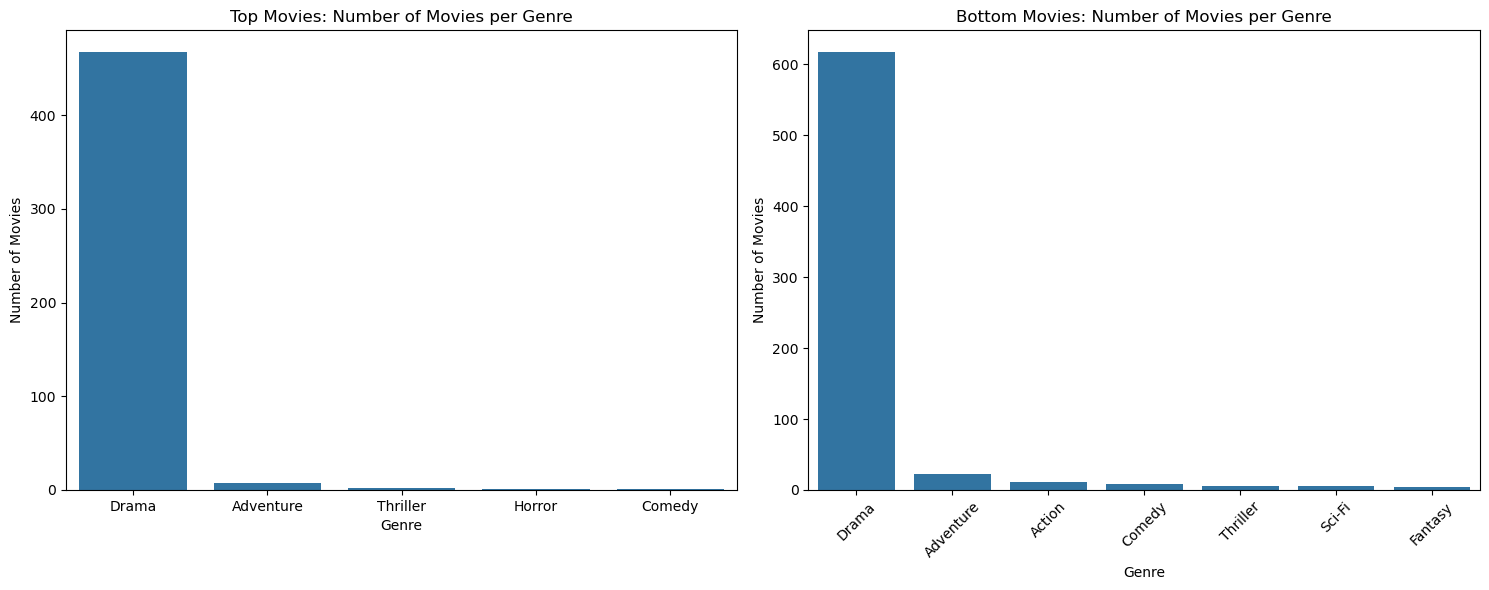

In [26]:
# Plot the number of movies per genre
# top movies
genre_percentages_top = pd.read_csv("movie_genre_percentages_NEW_MAPPING_TOP.csv")
genre_counts_top = genre_percentages_top['Top Genre'].value_counts()

# bottom movies
genre_percentages_bottom = pd.read_csv("movie_genre_percentages_NEW_MAPPING_BOTTOM.csv")
genre_counts_bottom = genre_percentages_bottom['Top Genre'].value_counts()

# Create a bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top movies
sns.barplot(x=genre_counts_top.index, y=genre_counts_top, ax=ax1)
ax1.set_title("Top Movies: Number of Movies per Genre")
ax1.set_xlabel("Genre")
ax1.set_ylabel("Number of Movies")

# Bottom movies
sns.barplot(x=genre_counts_bottom.index, y=genre_counts_bottom, ax=ax2)
ax2.set_title("Bottom Movies: Number of Movies per Genre")
ax2.set_xlabel("Genre")
ax2.set_ylabel("Number of Movies")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
